In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import PolynomialFeatures
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import time

import joblib

from scipy import stats

import os

In [3]:
# Load training data (already scaled)
data_dir = '../Data Files'
model_dir = '../Model Files'

train_scaled = pd.read_csv(os.path.join(data_dir, 'property_train_scaled.csv'))
X_train_scaled = train_scaled.drop('Harga_Properti', axis=1)
y_train = train_scaled['Harga_Properti']

# Load testing data (already scaled)
test_scaled = pd.read_csv(os.path.join(data_dir, 'property_test_scaled.csv'))
X_test_scaled = test_scaled.drop('Harga_Properti', axis=1)
y_test = test_scaled['Harga_Properti']

# Load scaler (for future predictions)
scaler = joblib.load(os.path.join(model_dir, 'property_scaler.pkl'))

print(f"   Training set: {X_train_scaled.shape}")
print(f"   Testing set: {X_test_scaled.shape}")

# GENERATE POLYNOMIAL FEATURES
poly_features = {}
X_train_poly = {}
X_test_poly = {}

degrees = [1, 2, 3, 4, 5]

   Training set: (175, 5)
   Testing set: (75, 5)


In [4]:
for degree in degrees:
    # Create polynomial features
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    
    # Transform training dan testing data
    X_train_poly[degree] = poly.fit_transform(X_train_scaled)
    X_test_poly[degree] = poly.transform(X_test_scaled)
    
    # Simpan polynomial transformer
    poly_features[degree] = poly
    
    # Display info
    n_features = X_train_poly[degree].shape[1]
    print(f"Degree {degree}: {n_features:4d} features | "
          f"Original: {X_train_scaled.shape[1]} → Expanded: {n_features}")


Degree 1:    5 features | Original: 5 → Expanded: 5
Degree 2:   20 features | Original: 5 → Expanded: 20
Degree 3:   55 features | Original: 5 → Expanded: 55
Degree 4:  125 features | Original: 5 → Expanded: 125
Degree 5:  251 features | Original: 5 → Expanded: 251


In [6]:
models = {
    'Linear Regression': {},
    'Ridge (α=0.1)': {},
    'Ridge (α=1)': {},
    'Ridge (α=10)': {},
    'Lasso (α=0.1)': {},
    'Lasso (α=1)': {},
    'Lasso (α=10)': {}
}

# Dictionary untuk menyimpan training time
training_times = {}

models


{'Linear Regression': {},
 'Ridge (α=0.1)': {},
 'Ridge (α=1)': {},
 'Ridge (α=10)': {},
 'Lasso (α=0.1)': {},
 'Lasso (α=1)': {},
 'Lasso (α=10)': {}}

In [7]:
for degree in degrees:
    start_time = time.time()
    
    model = LinearRegression()
    model.fit(X_train_poly[degree], y_train)
    
    end_time = time.time()
    training_time = end_time - start_time
    
    models['Linear Regression'][degree] = model
    training_times[f'LR_deg{degree}'] = training_time
    
    # Calculate R² scores
    train_score = model.score(X_train_poly[degree], y_train)
    test_score = model.score(X_test_poly[degree], y_test)
    
    print(f"   Degree {degree}: Train R²={train_score:.4f}, Test R²={test_score:.4f}, "
          f"Time={training_time:.4f}s")

   Degree 1: Train R²=0.7829, Test R²=0.7550, Time=0.0043s
   Degree 2: Train R²=0.9559, Test R²=0.9476, Time=0.0006s
   Degree 3: Train R²=0.9730, Test R²=0.9112, Time=0.0082s
   Degree 4: Train R²=0.9917, Test R²=0.8163, Time=0.0024s
   Degree 5: Train R²=1.0000, Test R²=-1.9117, Time=0.0081s


In [10]:
# Train Ridge Regression
print("RIDGE REGRESSION (L2 Regularization)")
alphas_ridge = [0.1, 1, 10]
for alpha in alphas_ridge:
    print(f"\n   Alpha = {alpha}:")
    for degree in degrees:
        start_time = time.time()
        
        model = Ridge(alpha=alpha)
        model.fit(X_train_poly[degree], y_train)
        
        end_time = time.time()
        training_time = end_time - start_time
        
        models[f'Ridge (α={alpha})'][degree] = model
        training_times[f'Ridge_a{alpha}_deg{degree}'] = training_time
        
        # Calculate R² scores
        train_score = model.score(X_train_poly[degree], y_train)
        test_score = model.score(X_test_poly[degree], y_test)
        
        print(f"      Degree {degree}: Train R²={train_score:.4f}, Test R²={test_score:.4f}, "
              f"Time={training_time:.4f}s")

RIDGE REGRESSION (L2 Regularization)

   Alpha = 0.1:
      Degree 1: Train R²=0.7829, Test R²=0.7550, Time=0.0013s
      Degree 2: Train R²=0.9558, Test R²=0.9475, Time=0.0007s
      Degree 3: Train R²=0.9729, Test R²=0.9133, Time=0.0008s
      Degree 4: Train R²=0.9907, Test R²=0.8742, Time=0.0012s
      Degree 5: Train R²=0.9999, Test R²=-1.4174, Time=0.0010s

   Alpha = 1:
      Degree 1: Train R²=0.7828, Test R²=0.7549, Time=0.0005s
      Degree 2: Train R²=0.9555, Test R²=0.9467, Time=0.0005s
      Degree 3: Train R²=0.9722, Test R²=0.9173, Time=0.0005s
      Degree 4: Train R²=0.9884, Test R²=0.8523, Time=0.0007s
      Degree 5: Train R²=0.9994, Test R²=-0.7439, Time=0.0009s

   Alpha = 10:
      Degree 1: Train R²=0.7817, Test R²=0.7531, Time=0.0005s
      Degree 2: Train R²=0.9440, Test R²=0.9328, Time=0.0005s
      Degree 3: Train R²=0.9673, Test R²=0.9119, Time=0.0005s
      Degree 4: Train R²=0.9840, Test R²=0.8773, Time=0.0030s
      Degree 5: Train R²=0.9965, Test R²=-0.6

In [12]:
# Train Lasso Regression
print("3. LASSO REGRESSION (L1 Regularization)")
alphas_lasso = [0.1, 1, 10]
for alpha in alphas_lasso:
    print(f"\n   Alpha = {alpha}:")
    for degree in degrees:
        start_time = time.time()
        
        model = Lasso(alpha=alpha, max_iter=10000)
        model.fit(X_train_poly[degree], y_train)
        
        end_time = time.time()
        training_time = end_time - start_time
        
        models[f'Lasso (α={alpha})'][degree] = model
        training_times[f'Lasso_a{alpha}_deg{degree}'] = training_time
        
        # Calculate R² scores
        train_score = model.score(X_train_poly[degree], y_train)
        test_score = model.score(X_test_poly[degree], y_test)
        
        print(f"      Degree {degree}: Train R²={train_score:.4f}, Test R²={test_score:.4f}, "
              f"Time={training_time:.4f}s")

3. LASSO REGRESSION (L1 Regularization)

   Alpha = 0.1:
      Degree 1: Train R²=0.7829, Test R²=0.7550, Time=0.0010s
      Degree 2: Train R²=0.9559, Test R²=0.9475, Time=0.0017s
      Degree 3: Train R²=0.9729, Test R²=0.9134, Time=0.0557s
      Degree 4: Train R²=0.9906, Test R²=0.8873, Time=0.1181s
      Degree 5: Train R²=0.9984, Test R²=0.1710, Time=0.2366s

   Alpha = 1:
      Degree 1: Train R²=0.7829, Test R²=0.7549, Time=0.0006s
      Degree 2: Train R²=0.9558, Test R²=0.9467, Time=0.0008s
      Degree 3: Train R²=0.9723, Test R²=0.9220, Time=0.0468s
      Degree 4: Train R²=0.9870, Test R²=0.8758, Time=0.1139s
      Degree 5: Train R²=0.9955, Test R²=0.3449, Time=0.2142s

   Alpha = 10:
      Degree 1: Train R²=0.7825, Test R²=0.7538, Time=0.0006s
      Degree 2: Train R²=0.9519, Test R²=0.9383, Time=0.0007s
      Degree 3: Train R²=0.9645, Test R²=0.9162, Time=0.0111s
      Degree 4: Train R²=0.9746, Test R²=0.8975, Time=0.0934s
      Degree 5: Train R²=0.9838, Test R²=0.4

In [13]:
class PolynomialRegressionFromScratch:
    """
    Custom implementation of Polynomial Regression using Adam Optimizer
    """
    def __init__(self, learning_rate=0.001, n_iterations=1000, regularization=None, alpha=0.1, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.regularization = regularization  # None, 'l1', 'l2'
        self.alpha = alpha # Regularization strength
        self.beta1 = beta1 # Adam parameter
        self.beta2 = beta2 # Adam parameter
        self.epsilon = epsilon # Adam parameter for numerical stability
        self.weights = None
        self.bias = None
        self.cost_history = []
        self.m_w, self.v_w = None, None # Adam moments for weights
        self.m_b, self.v_b = None, None # Adam moments for bias


    # Removed _polynomial_features method as we will use pre-generated features

    def fit(self, X_poly, y):
        """Train the model using Adam optimizer"""
        # X_poly is expected to be the pre-generated polynomial features

        n_samples, n_features = X_poly.shape

        # Initialize weights and bias
        self.weights = np.zeros(n_features)
        self.bias = 0

        # Initialize Adam moments
        self.m_w = np.zeros(n_features)
        self.v_w = np.zeros(n_features)
        self.m_b = 0
        self.v_b = 0

        # Adam Optimization
        for i in range(self.n_iterations):
            # Forward pass
            y_pred = np.dot(X_poly, self.weights) + self.bias

            # Calculate cost (MSE)
            cost = np.mean((y_pred - y) ** 2)

            # Add regularization to cost
            if self.regularization == 'l2':
                cost += self.alpha * np.sum(self.weights ** 2)
            elif self.regularization == 'l1':
                cost += self.alpha * np.sum(np.abs(self.weights))

            self.cost_history.append(cost)

            # Calculate gradients
            dw = (2 / n_samples) * np.dot(X_poly.T, (y_pred - y))
            db = (2 / n_samples) * np.sum(y_pred - y)

            # Add regularization gradient
            if self.regularization == 'l2':
                dw += 2 * self.alpha * self.weights
            elif self.regularization == 'l1':
                dw += self.alpha * np.sign(self.weights)


            # Update Adam moments
            self.m_w = self.beta1 * self.m_w + (1 - self.beta1) * dw
            self.v_w = self.beta2 * self.v_w + (1 - self.beta2) * (dw ** 2)
            self.m_b = self.beta1 * self.m_b + (1 - self.beta1) * db
            self.v_b = self.beta2 * self.v_b + (1 - self.beta2) * (db ** 2)

            # Bias correction
            m_w_corrected = self.m_w / (1 - self.beta1**(i+1))
            v_w_corrected = self.v_w / (1 - self.beta2**(i+1))
            m_b_corrected = self.m_b / (1 - self.beta1**(i+1))
            v_b_corrected = self.v_b / (1 - self.beta2**(i+1))


            # Update weights and bias
            self.weights -= self.learning_rate * m_w_corrected / (np.sqrt(v_w_corrected) + self.epsilon)
            self.bias -= self.learning_rate * m_b_corrected / (np.sqrt(v_b_corrected) + self.epsilon)


            # Check for NaN in weights or bias
            if np.isnan(self.weights).any() or np.isnan(self.bias):
                print(f"NaN detected in weights or bias at iteration {i}. Stopping training.")
                break

            # Optional: Print cost every few iterations to monitor convergence
            # if (i + 1) % 10000 == 0:
            #      print(f"Iteration {i+1}, Cost: {cost:.4f}")


        return self

    def predict(self, X_poly):
        """Make predictions"""
        # X_poly is expected to be the pre-generated polynomial features
        return np.dot(X_poly, self.weights) + self.bias

    def score(self, X_poly, y):
        """Calculate R² score"""
        y_pred = self.predict(X_poly)
        ss_res = np.sum((y - y_pred) ** 2)
        ss_tot = np.sum((y - np.mean(y)) ** 2)
        # Handle case where ss_tot is zero or ss_res is NaN
        if ss_tot == 0:
            return 1.0 if ss_res == 0 else 0.0
        if np.isnan(ss_res):
            return np.nan
        return 1 - (ss_res / ss_tot)

In [14]:
custom_models_tuned = {}

# Experiment with different beta values for Adam
beta_combinations = [(0.9, 0.999)] # Focusing on default betas for now

for beta1, beta2 in beta_combinations:
    print(f"\n--- Testing with beta1={beta1}, beta2={beta2} ---")
    for degree in [1, 2, 3]:  # Test with lower degrees for efficiency
        print(f"\nDegree {degree}:")

        # --- Train Custom Model without Regularization (Adam) ---
        start_time = time.time()
        current_learning_rate = 0.001
        current_iterations = 50000
        if degree == 2:
            current_learning_rate = 0.0005
            current_iterations = 100000
        elif degree == 3:
            current_learning_rate = 0.0001
            current_iterations = 200000

        model_custom_no_reg = PolynomialRegressionFromScratch(
            learning_rate=current_learning_rate,
            n_iterations=current_iterations,
            beta1=beta1,
            beta2=beta2
        )
        model_custom_no_reg.fit(X_train_poly[degree], y_train.values)
        end_time = time.time()
        training_time_no_reg = end_time - start_time

        train_score_no_reg = model_custom_no_reg.score(X_train_poly[degree], y_train.values)
        test_score_no_reg = model_custom_no_reg.score(X_test_poly[degree], y_test.values)

        print(f"   Custom (No Reg): Train R²={train_score_no_reg:.4f}, Test R²={test_score_no_reg:.4f}, "
              f"Time={training_time_no_reg:.4f}s")

        # --- Train Custom Model with L2 Regularization (Ridge) ---
        print("   Custom (L2 Reg):")
        alphas_ridge = [0.1, 1, 10]
        for alpha in alphas_ridge:
            start_time = time.time()
            model_custom_l2 = PolynomialRegressionFromScratch(
                learning_rate=current_learning_rate, # Use same learning rate as no reg for comparison
                n_iterations=current_iterations, # Use same iterations as no reg
                regularization='l2',
                alpha=alpha,
                beta1=beta1,
                beta2=beta2
            )
            model_custom_l2.fit(X_train_poly[degree], y_train.values)
            end_time = time.time()
            training_time_l2 = end_time - start_time

            train_score_l2 = model_custom_l2.score(X_train_poly[degree], y_train.values)
            test_score_l2 = model_custom_l2.score(X_test_poly[degree], y_test.values)

            print(f"      Alpha={alpha}: Train R²={train_score_l2:.4f}, Test R²={test_score_l2:.4f}, "
                  f"Time={training_time_l2:.4f}s")

        # --- Train Custom Model with L1 Regularization (Lasso) ---
        print("   Custom (L1 Reg):")
        alphas_lasso = [0.1, 1, 10]
        for alpha in alphas_lasso:
            start_time = time.time()
            model_custom_l1 = PolynomialRegressionFromScratch(
                learning_rate=current_learning_rate, # Use same learning rate as no reg
                n_iterations=current_iterations, # Use same iterations as no reg
                regularization='l1',
                alpha=alpha,
                beta1=beta1,
                beta2=beta2
            )
            model_custom_l1.fit(X_train_poly[degree], y_train.values)
            end_time = time.time()
            training_time_l1 = end_time - start_time

            train_score_l1 = model_custom_l1.score(X_train_poly[degree], y_train.values)
            test_score_l1 = model_custom_l1.score(X_test_poly[degree], y_test.values)

            print(f"      Alpha={alpha}: Train R²={train_score_l1:.4f}, Test R²={test_score_l1:.4f}, "
                  f"Time={training_time_l1:.4f}s")


        # --- Compare with Sklearn ---
        sklearn_model = models['Linear Regression'][degree]
        sklearn_train = sklearn_model.score(X_train_poly[degree], y_train)
        sklearn_test = sklearn_model.score(X_test_poly[degree], y_test)

        print(f"   Sklearn Implementation: Train R²={sklearn_train:.4f}, Test R²={sklearn_test:.4f}")
        print(f"   Difference (No Reg): Train Δ={abs(train_score_no_reg - sklearn_train):.4f}, "
              f"Test Δ={abs(test_score_no_reg - sklearn_test):.4f}")


--- Testing with beta1=0.9, beta2=0.999 ---

Degree 1:
   Custom (No Reg): Train R²=-14.5721, Test R²=-13.4771, Time=1.1912s
   Custom (L2 Reg):
      Alpha=0.1: Train R²=-14.5721, Test R²=-13.4771, Time=1.4022s
      Alpha=1: Train R²=-14.5727, Test R²=-13.4776, Time=1.3965s
      Alpha=10: Train R²=-14.5997, Test R²=-13.4965, Time=1.4228s
   Custom (L1 Reg):
      Alpha=0.1: Train R²=-14.5721, Test R²=-13.4771, Time=1.4216s
      Alpha=1: Train R²=-14.5721, Test R²=-13.4771, Time=1.4049s
      Alpha=10: Train R²=-14.5721, Test R²=-13.4771, Time=1.4779s
   Sklearn Implementation: Train R²=0.7829, Test R²=0.7550
   Difference (No Reg): Train Δ=15.3549, Test Δ=14.2321

Degree 2:
   Custom (No Reg): Train R²=-5.4951, Test R²=-5.3540, Time=2.4399s
   Custom (L2 Reg):
      Alpha=0.1: Train R²=-5.4951, Test R²=-5.3543, Time=2.8456s
      Alpha=1: Train R²=-5.4956, Test R²=-5.3558, Time=2.8405s
      Alpha=10: Train R²=-5.5553, Test R²=-5.3543, Time=2.8331s
   Custom (L1 Reg):
      Alpha=

In [19]:
# model evaluation 
def calculate_mape(y_true, y_pred):
    """Calculate Mean Absolute Percentage Error"""
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [20]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
    """Calculate all metrics for a model"""
    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Metrics
    metrics = {
        'train': {
            'R²': r2_score(y_train, y_train_pred),
            'MSE': mean_squared_error(y_train, y_train_pred),
            'RMSE': np.sqrt(mean_squared_error(y_train, y_train_pred)),
            'MAE': mean_absolute_error(y_train, y_train_pred),
            'MAPE': calculate_mape(y_train, y_train_pred)
        },
        'test': {
            'R²': r2_score(y_test, y_test_pred),
            'MSE': mean_squared_error(y_test, y_test_pred),
            'RMSE': np.sqrt(mean_squared_error(y_test, y_test_pred)),
            'MAE': mean_absolute_error(y_test, y_test_pred),
            'MAPE': calculate_mape(y_test, y_test_pred)
        }
    }
    
    return metrics, y_train_pred, y_test_pred


In [22]:
# Calculate metrics for all models
all_metrics = {}


for model_name in models.keys():
    all_metrics[model_name] = {}
    
    for degree in degrees:
        model = models[model_name][degree]
        metrics, _, _ = evaluate_model(
            model, 
            X_train_poly[degree], 
            X_test_poly[degree],
            y_train, 
            y_test
        )

        print(f"\nMetrics for {model_name} (Degree {degree}):")
        print(f"  Train R²: {metrics['train']['R²']:.4f}, Test R²: {metrics['test']['R²']:.4f}")
        print(f"  Train MSE: {metrics['train']['MSE']:.4f}, Test MSE: {metrics['test']['MSE']:.4f}")
        print(f"  Train RMSE: {metrics['train']['RMSE']:.4f}, Test RMSE: {metrics['test']['RMSE']:.4f}")
        print(f"  Train MAE: {metrics['train']['MAE']:.4f}, Test MAE: {metrics['test']['MAE']:.4f}")
        print(f"  Train MAPE: {metrics['train']['MAPE']:.4f}%, Test MAPE: {metrics['test']['MAPE']:.4f}%")
        all_metrics[model_name][degree] = metrics



Metrics for Linear Regression (Degree 1):
  Train R²: 0.7829, Test R²: 0.7550
  Train MSE: 168392.3098, Test MSE: 205391.2602
  Train RMSE: 410.3563, Test RMSE: 453.2011
  Train MAE: 336.0796, Test MAE: 385.2971
  Train MAPE: 8.6202%, Test MAPE: 9.8641%

Metrics for Linear Regression (Degree 2):
  Train R²: 0.9559, Test R²: 0.9476
  Train MSE: 34235.9488, Test MSE: 43963.6765
  Train RMSE: 185.0296, Test RMSE: 209.6752
  Train MAE: 148.6840, Test MAE: 161.6176
  Train MAPE: 3.8111%, Test MAPE: 3.9736%

Metrics for Linear Regression (Degree 3):
  Train R²: 0.9730, Test R²: 0.9112
  Train MSE: 20970.7551, Test MSE: 74439.1113
  Train RMSE: 144.8128, Test RMSE: 272.8353
  Train MAE: 115.3084, Test MAE: 201.8374
  Train MAPE: 2.9765%, Test MAPE: 5.1384%

Metrics for Linear Regression (Degree 4):
  Train R²: 0.9917, Test R²: 0.8163
  Train MSE: 6447.9928, Test MSE: 154044.5760
  Train RMSE: 80.2994, Test RMSE: 392.4851
  Train MAE: 60.9118, Test MAE: 292.2082
  Train MAPE: 1.5840%, Test MA

In [27]:
comparison_data = []

for model_name in models.keys():
    for degree in degrees:
        metrics = all_metrics[model_name][degree]
        
        comparison_data.append({
            'Model': model_name,
            'Degree': degree,
            'Train_R²': metrics['train']['R²'],
            'Test_R²': metrics['test']['R²'],
            'Train_RMSE': metrics['train']['RMSE'],
            'Test_RMSE': metrics['test']['RMSE'],
            'Train_MAE': metrics['train']['MAE'],
            'Test_MAE': metrics['test']['MAE'],
            'Train_MAPE': metrics['train']['MAPE'],
            'Test_MAPE': metrics['test']['MAPE'],
            'Overfit_Score': metrics['train']['R²'] - metrics['test']['R²']
        })

comparison_df = pd.DataFrame(comparison_data)

# Display top models by Test R²
print("\n🏆 TOP 10 MODELS BY TEST R² SCORE:")
top_models = comparison_df.nlargest(10, 'Test_R²')
print(top_models[['Model', 'Degree', 'Train_R²', 'Test_R²', 'Test_RMSE', 'Overfit_Score']].to_string(index=False))

# Display models with least overfitting
print("\n⚖️ TOP 10 MODELS WITH LEAST OVERFITTING:")
least_overfit = comparison_df.nsmallest(10, 'Overfit_Score')
print(least_overfit[['Model', 'Degree', 'Train_R²', 'Test_R²', 'Overfit_Score']].to_string(index=False))

# Save full comparison table
print("\n📊 FULL METRICS TABLE (showing first 20 rows):")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
print(comparison_df.head(20).round(4))

# Save to CSV in the /Results directory using os.path.join
results_dir = '../Results'
os.makedirs(results_dir, exist_ok=True)
comparison_df.to_csv(os.path.join(results_dir, 'model_comparison_metrics.csv'), index=False)


🏆 TOP 10 MODELS BY TEST R² SCORE:
            Model  Degree  Train_R²  Test_R²  Test_RMSE  Overfit_Score
Linear Regression       2  0.955853 0.947566 209.675169       0.008287
    Ridge (α=0.1)       2  0.955849 0.947501 209.805608       0.008348
    Lasso (α=0.1)       2  0.955852 0.947490 209.827703       0.008362
      Lasso (α=1)       2  0.955799 0.946745 211.310770       0.009054
      Ridge (α=1)       2  0.955536 0.946657 211.485424       0.008879
     Lasso (α=10)       2  0.951935 0.938307 227.435510       0.013628
     Ridge (α=10)       2  0.944022 0.932777 237.410537       0.011245
      Lasso (α=1)       3  0.972336 0.922034 255.677358       0.050302
      Ridge (α=1)       3  0.972223 0.917325 263.285486       0.054897
     Lasso (α=10)       3  0.964500 0.916205 265.063006       0.048294

⚖️ TOP 10 MODELS WITH LEAST OVERFITTING:
            Model  Degree  Train_R²  Test_R²  Overfit_Score
Linear Regression       2  0.955853 0.947566       0.008287
    Ridge (α=0.1)     


1. PLOTTING LEARNING CURVES...


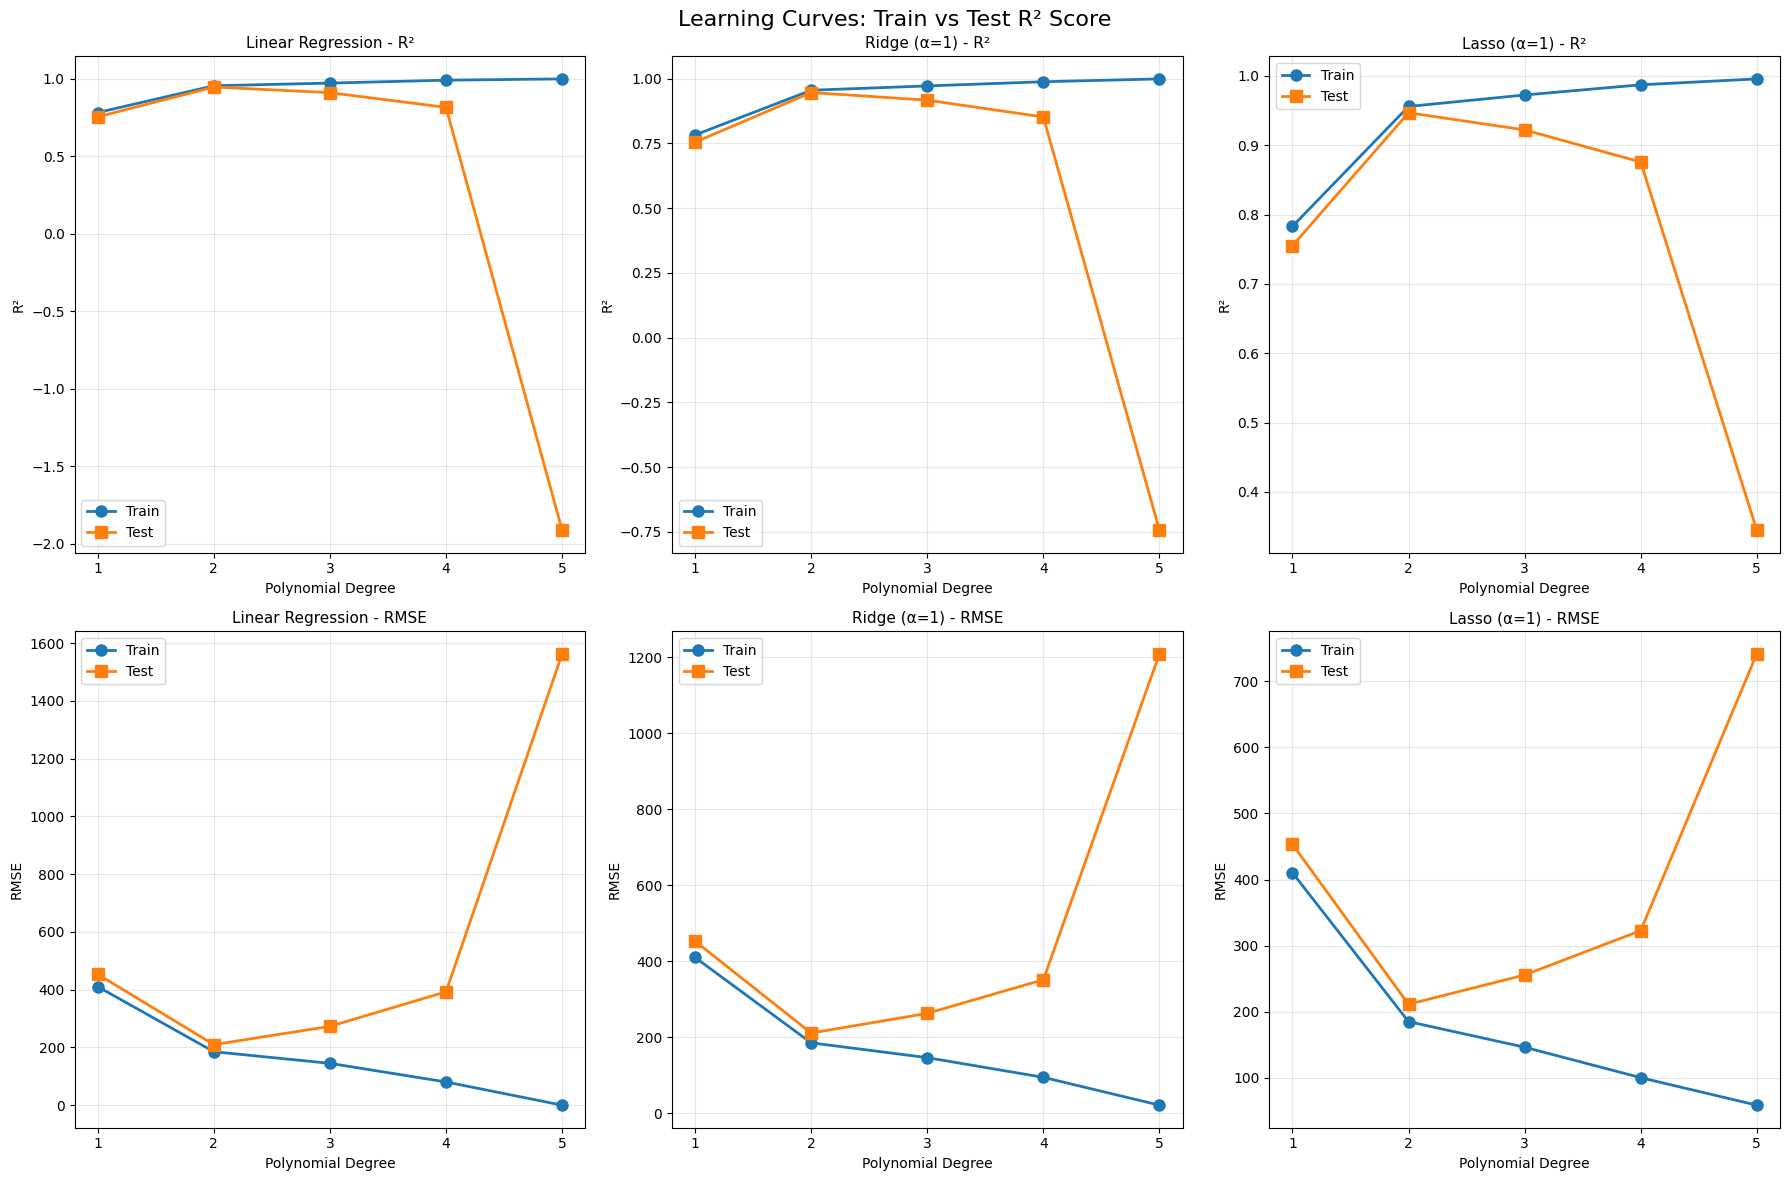

In [28]:
#OVERFITTING & UNDERFITTING ANALYSIS
# 1. Learning Curves
print("\n1. PLOTTING LEARNING CURVES...")

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Learning Curves: Train vs Test R² Score', fontsize=16)

plot_idx = 0
for i, model_name in enumerate(['Linear Regression', 'Ridge (α=1)', 'Lasso (α=1)']):
    for j, metric in enumerate(['R²', 'RMSE']):
        ax = axes[j, i]
        
        train_scores = []
        test_scores = []
        
        for degree in degrees:
            if metric == 'R²':
                train_scores.append(all_metrics[model_name][degree]['train']['R²'])
                test_scores.append(all_metrics[model_name][degree]['test']['R²'])
            else:
                train_scores.append(all_metrics[model_name][degree]['train']['RMSE'])
                test_scores.append(all_metrics[model_name][degree]['test']['RMSE'])
        
        ax.plot(degrees, train_scores, 'o-', label='Train', linewidth=2, markersize=8)
        ax.plot(degrees, test_scores, 's-', label='Test', linewidth=2, markersize=8)
        
        ax.set_xlabel('Polynomial Degree', fontsize=10)
        ax.set_ylabel(metric, fontsize=10)
        ax.set_title(f'{model_name} - {metric}', fontsize=11)
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.set_xticks(degrees)

plt.tight_layout()
plt.show()


2. BIAS-VARIANCE TRADE-OFF ANALYSIS:


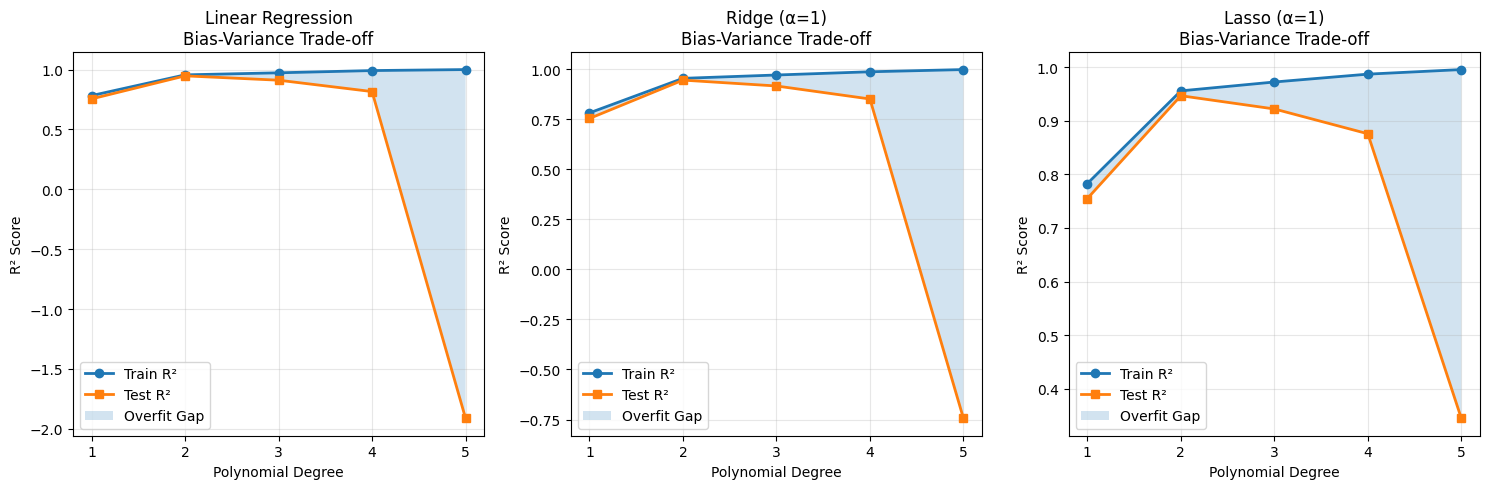

In [29]:
# 2. Bias-Variance Trade-off Analysis
print("\n2. BIAS-VARIANCE TRADE-OFF ANALYSIS:")

plt.figure(figsize=(15, 5))

for idx, model_name in enumerate(['Linear Regression', 'Ridge (α=1)', 'Lasso (α=1)']):
    plt.subplot(1, 3, idx+1)
    
    train_r2 = [all_metrics[model_name][d]['train']['R²'] for d in degrees]
    test_r2 = [all_metrics[model_name][d]['test']['R²'] for d in degrees]
    gap = [train_r2[i] - test_r2[i] for i in range(len(degrees))]
    
    plt.plot(degrees, train_r2, 'o-', label='Train R²', linewidth=2)
    plt.plot(degrees, test_r2, 's-', label='Test R²', linewidth=2)
    plt.fill_between(degrees, test_r2, train_r2, alpha=0.2, label='Overfit Gap')
    
    plt.xlabel('Polynomial Degree')
    plt.ylabel('R² Score')
    plt.title(f'{model_name}\nBias-Variance Trade-off')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(degrees)

plt.tight_layout()
plt.show()

In [30]:
# 3. Identify Underfitting, Overfitting, and Optimal Models
print("\n3. MODEL CATEGORIZATION:")

for model_name in ['Linear Regression', 'Ridge (α=1)', 'Lasso (α=1)']:
    print(f"\n{model_name}:")
    print("-" * 50)
    
    for degree in degrees:
        train_r2 = all_metrics[model_name][degree]['train']['R²']
        test_r2 = all_metrics[model_name][degree]['test']['R²']
        gap = train_r2 - test_r2
        
        # Categorization logic
        if test_r2 < 0.7:
            category = "❌ UNDERFITTING (High Bias)"
        elif gap > 0.15:
            category = "⚠️ OVERFITTING (High Variance)"
        elif gap > 0.10:
            category = "⚡ SLIGHT OVERFITTING"
        else:
            category = "✅ OPTIMAL (Balanced)"
        
        print(f"Degree {degree}: Train R²={train_r2:.4f}, Test R²={test_r2:.4f}, "
              f"Gap={gap:.4f} → {category}")



3. MODEL CATEGORIZATION:

Linear Regression:
--------------------------------------------------
Degree 1: Train R²=0.7829, Test R²=0.7550, Gap=0.0278 → ✅ OPTIMAL (Balanced)
Degree 2: Train R²=0.9559, Test R²=0.9476, Gap=0.0083 → ✅ OPTIMAL (Balanced)
Degree 3: Train R²=0.9730, Test R²=0.9112, Gap=0.0617 → ✅ OPTIMAL (Balanced)
Degree 4: Train R²=0.9917, Test R²=0.8163, Gap=0.1754 → ⚠️ OVERFITTING (High Variance)
Degree 5: Train R²=1.0000, Test R²=-1.9117, Gap=2.9117 → ❌ UNDERFITTING (High Bias)

Ridge (α=1):
--------------------------------------------------
Degree 1: Train R²=0.7828, Test R²=0.7549, Gap=0.0279 → ✅ OPTIMAL (Balanced)
Degree 2: Train R²=0.9555, Test R²=0.9467, Gap=0.0089 → ✅ OPTIMAL (Balanced)
Degree 3: Train R²=0.9722, Test R²=0.9173, Gap=0.0549 → ✅ OPTIMAL (Balanced)
Degree 4: Train R²=0.9884, Test R²=0.8523, Gap=0.1360 → ⚡ SLIGHT OVERFITTING
Degree 5: Train R²=0.9994, Test R²=-0.7439, Gap=1.7433 → ❌ UNDERFITTING (High Bias)

Lasso (α=1):
------------------------------


4. OVERFITTING SCORE HEATMAP:


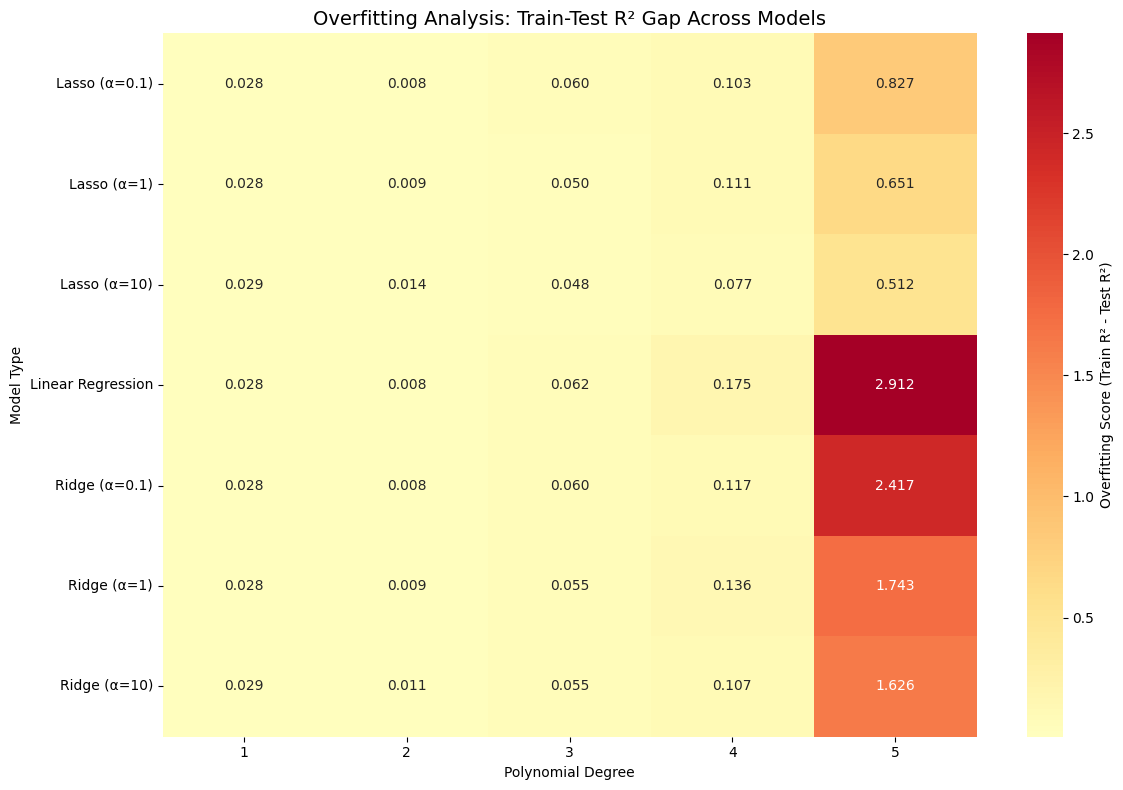

In [31]:
# 4. Overfitting Score Analysis
print("\n4. OVERFITTING SCORE HEATMAP:")

# Create pivot table for heatmap
pivot_data = comparison_df.pivot_table(
    values='Overfit_Score', 
    index='Model', 
    columns='Degree'
)

plt.figure(figsize=(12, 8))
sns.heatmap(pivot_data, annot=True, fmt='.3f', cmap='RdYlGn_r', center=0,
            cbar_kws={'label': 'Overfitting Score (Train R² - Test R²)'})
plt.title('Overfitting Analysis: Train-Test R² Gap Across Models', fontsize=14)
plt.xlabel('Polynomial Degree')
plt.ylabel('Model Type')
plt.tight_layout()
plt.show()

In [32]:
#VISUALIZATION

# Select best model for visualization
best_model_row = comparison_df.loc[comparison_df['Test_R²'].idxmax()]
best_model_name = best_model_row['Model']
best_degree = int(best_model_row['Degree'])

print(f"\n🏆 Best Model: {best_model_name} (Degree {best_degree})")
print(f"   Test R² = {best_model_row['Test_R²']:.4f}")
print(f"   Test RMSE = {best_model_row['Test_RMSE']:.4f}")

best_model = models[best_model_name][best_degree]

# 1. Predicted vs Actual Values
print("\n1. PREDICTED VS ACTUAL VALUES PLOT:")

_, y_train_pred_best, y_test_pred_best = evaluate_model(
    best_model,
    X_train_poly[best_degree],
    X_test_poly[best_degree],
    y_train,
    y_test
)


🏆 Best Model: Linear Regression (Degree 2)
   Test R² = 0.9476
   Test RMSE = 209.6752

1. PREDICTED VS ACTUAL VALUES PLOT:


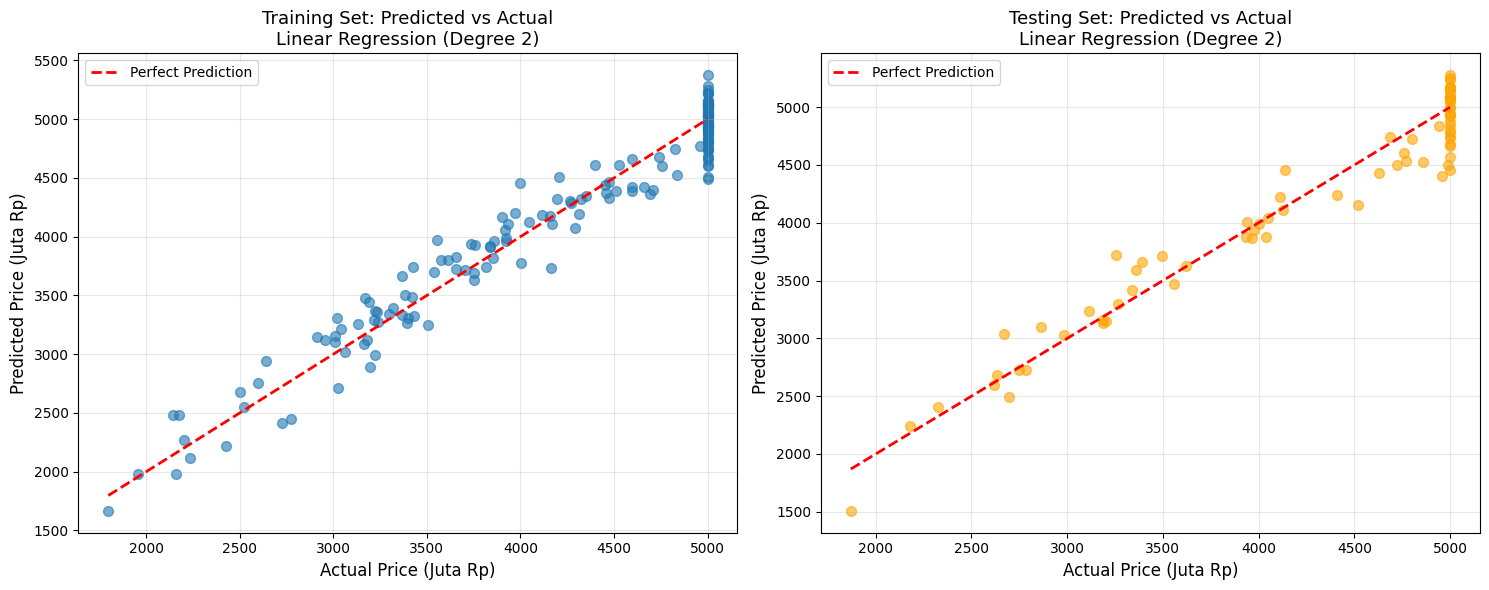


2. RESIDUAL ANALYSIS PLOTS:


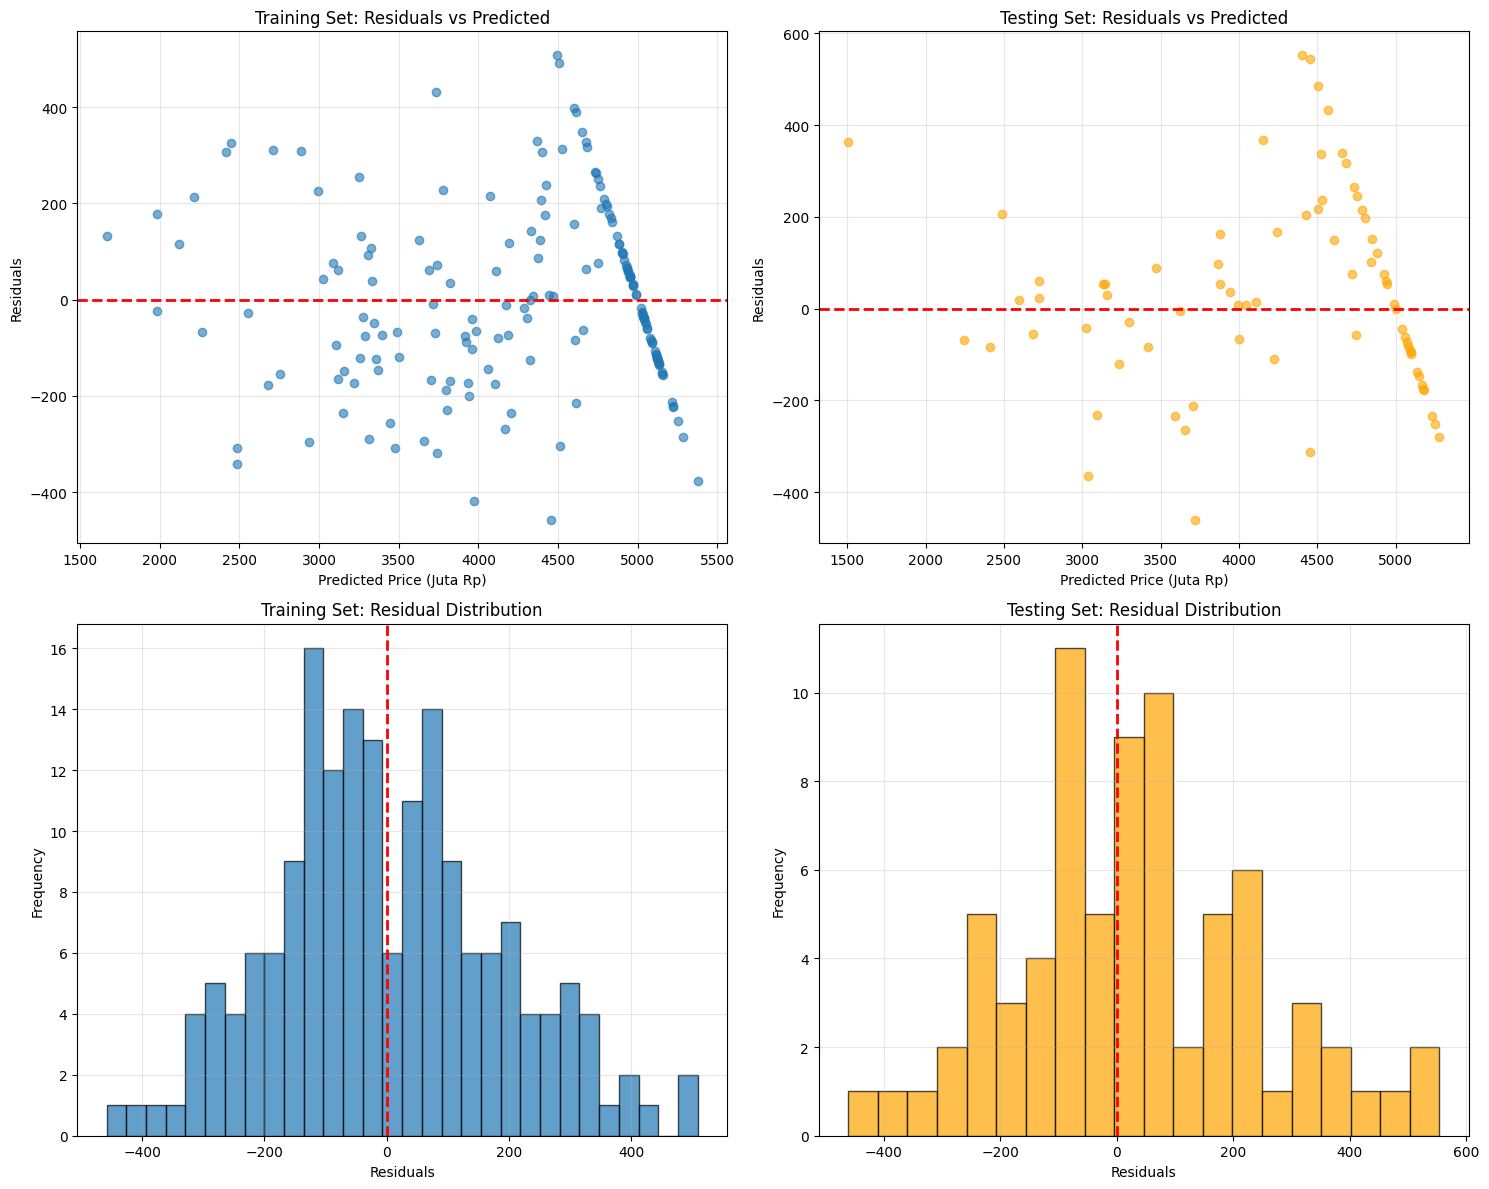

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Training set
axes[0].scatter(y_train, y_train_pred_best, alpha=0.6, s=50)
axes[0].plot([y_train.min(), y_train.max()], 
             [y_train.min(), y_train.max()], 
             'r--', linewidth=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Price (Juta Rp)', fontsize=12)
axes[0].set_ylabel('Predicted Price (Juta Rp)', fontsize=12)
axes[0].set_title(f'Training Set: Predicted vs Actual\n{best_model_name} (Degree {best_degree})', 
                  fontsize=13)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Testing set
axes[1].scatter(y_test, y_test_pred_best, alpha=0.6, s=50, color='orange')
axes[1].plot([y_test.min(), y_test.max()], 
             [y_test.min(), y_test.max()], 
             'r--', linewidth=2, label='Perfect Prediction')
axes[1].set_xlabel('Actual Price (Juta Rp)', fontsize=12)
axes[1].set_ylabel('Predicted Price (Juta Rp)', fontsize=12)
axes[1].set_title(f'Testing Set: Predicted vs Actual\n{best_model_name} (Degree {best_degree})', 
                  fontsize=13)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 2. Residual Plots
print("\n2. RESIDUAL ANALYSIS PLOTS:")

train_residuals = y_train - y_train_pred_best
test_residuals = y_test - y_test_pred_best

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Residuals vs Predicted (Train)
axes[0, 0].scatter(y_train_pred_best, train_residuals, alpha=0.6)
axes[0, 0].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[0, 0].set_xlabel('Predicted Price (Juta Rp)')
axes[0, 0].set_ylabel('Residuals')
axes[0, 0].set_title('Training Set: Residuals vs Predicted')
axes[0, 0].grid(True, alpha=0.3)

# Residuals vs Predicted (Test)
axes[0, 1].scatter(y_test_pred_best, test_residuals, alpha=0.6, color='orange')
axes[0, 1].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[0, 1].set_xlabel('Predicted Price (Juta Rp)')
axes[0, 1].set_ylabel('Residuals')
axes[0, 1].set_title('Testing Set: Residuals vs Predicted')
axes[0, 1].grid(True, alpha=0.3)

# Residual Distribution (Train)
axes[1, 0].hist(train_residuals, bins=30, alpha=0.7, edgecolor='black')
axes[1, 0].axvline(x=0, color='r', linestyle='--', linewidth=2)
axes[1, 0].set_xlabel('Residuals')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Training Set: Residual Distribution')
axes[1, 0].grid(True, alpha=0.3)

# Residual Distribution (Test)
axes[1, 1].hist(test_residuals, bins=20, alpha=0.7, edgecolor='black', color='orange')
axes[1, 1].axvline(x=0, color='r', linestyle='--', linewidth=2)
axes[1, 1].set_xlabel('Residuals')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Testing Set: Residual Distribution')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [34]:
data_dir = '../Data Files'

df = pd.read_csv(os.path.join(data_dir, 'property_full_dataset.csv'))

df.head()

,Luas_Tanah,Luas_Bangunan,Jumlah_Kamar_Tidur,Umur_Bangunan,Jarak_ke_Pusat_Kota,Harga_Properti
0,218.54,138.95,1,0,15.01,3852.44
1,477.82,172.49,1,5,9.59,5000.00
2,379.40,344.92,1,17,5.27,5000.00
3,319.40,147.26,5,23,9.60,5000.00
4,120.21,92.71,4,9,3.68,3970.43



3. POLYNOMIAL CURVES FOR IMPORTANT FEATURES:
   Top 2 most important features: ['Luas_Bangunan', 'Luas_Tanah']


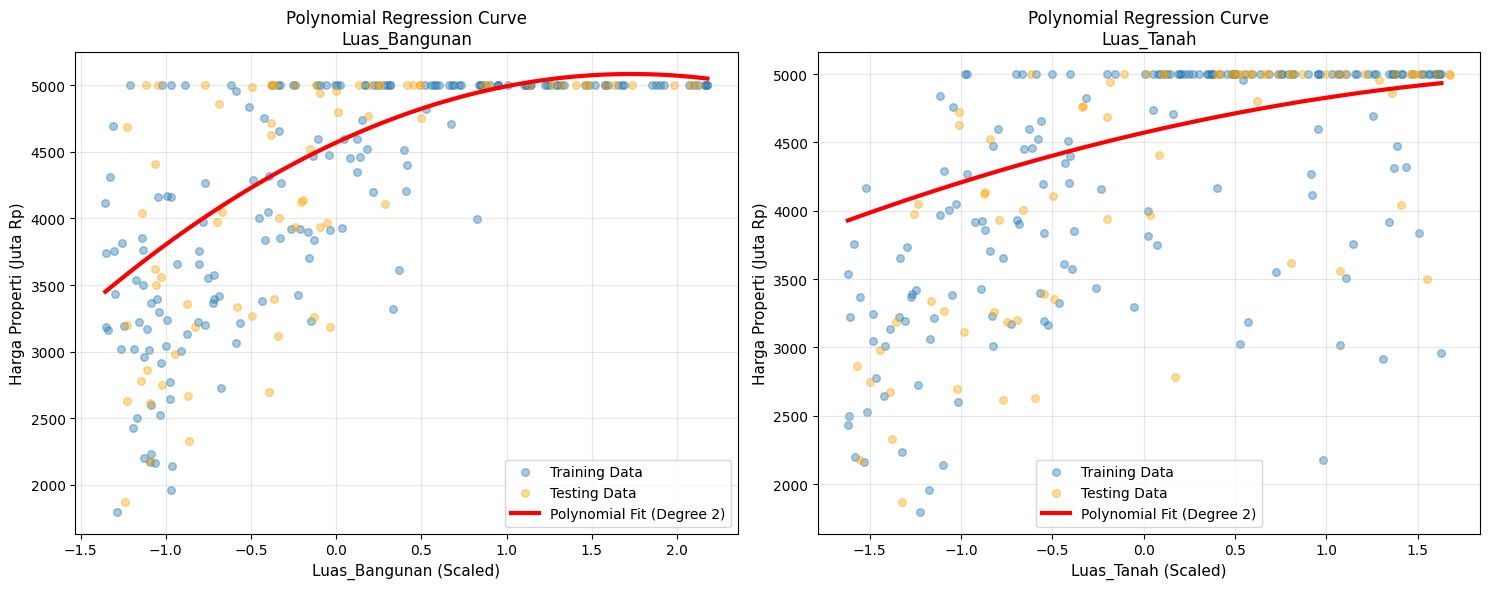

In [35]:
# 3. Polynomial Curve for Important Features
print("\n3. POLYNOMIAL CURVES FOR IMPORTANT FEATURES:")

# Get feature importance (correlation with price)
feature_importance = df[['Luas_Tanah', 'Luas_Bangunan', 'Jarak_ke_Pusat_Kota']].corrwith(df['Harga_Properti']).abs()
top_2_features = feature_importance.nlargest(2).index.tolist()

print(f"   Top 2 most important features: {top_2_features}")

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

for idx, feature in enumerate(top_2_features):
    ax = axes[idx]
    
    # Get feature index
    feature_idx = list(X_train_scaled.columns).index(feature)
    
    # Create range for plotting
    feature_range = np.linspace(
        X_train_scaled[feature].min(),
        X_train_scaled[feature].max(),
        100
    ).reshape(-1, 1)
    
    # Create dummy data (mean values for other features)
    X_dummy = np.tile(X_train_scaled.mean().values, (100, 1))
    X_dummy[:, feature_idx] = feature_range.flatten()
    
    # Transform to polynomial
    X_dummy_poly = poly_features[best_degree].transform(X_dummy)
    
    # Predict
    y_curve = best_model.predict(X_dummy_poly)
    
    # Plot
    ax.scatter(X_train_scaled[feature], y_train, alpha=0.4, s=30, label='Training Data')
    ax.scatter(X_test_scaled[feature], y_test, alpha=0.4, s=30, label='Testing Data', color='orange')
    ax.plot(feature_range, y_curve, 'r-', linewidth=3, label=f'Polynomial Fit (Degree {best_degree})')
    
    ax.set_xlabel(f'{feature} (Scaled)', fontsize=11)
    ax.set_ylabel('Harga Properti (Juta Rp)', fontsize=11)
    ax.set_title(f'Polynomial Regression Curve\n{feature}', fontsize=12)
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [36]:
#REGULARIZATION ANALYSIS

# Extended alpha values for comprehensive analysis
alphas_extended = [0.001, 0.01, 0.1, 1, 10, 100]

# Dictionary untuk menyimpan hasil
ridge_results = {degree: {'alphas': [], 'train_r2': [], 'test_r2': [], 'train_rmse': [], 'test_rmse': []} 
                 for degree in [2, 3, 4]}
lasso_results = {degree: {'alphas': [], 'train_r2': [], 'test_r2': [], 'train_rmse': [], 'test_rmse': []} 
                 for degree in [2, 3, 4]}

print("\nTraining Ridge and Lasso with extended alpha values...")
print("-" * 70)

# Train models untuk polynomial degree 2, 3, 4
for degree in [2, 3, 4]:
    print(f"\n{'='*50}")
    print(f"DEGREE {degree} POLYNOMIAL")
    print(f"{'='*50}")
    
    print(f"\nRidge Regression:")
    for alpha in alphas_extended:
        # Ridge
        ridge_model = Ridge(alpha=alpha)
        ridge_model.fit(X_train_poly[degree], y_train)
        
        train_r2 = ridge_model.score(X_train_poly[degree], y_train)
        test_r2 = ridge_model.score(X_test_poly[degree], y_test)
        
        y_train_pred = ridge_model.predict(X_train_poly[degree])
        y_test_pred = ridge_model.predict(X_test_poly[degree])
        
        train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
        test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
        
        ridge_results[degree]['alphas'].append(alpha)
        ridge_results[degree]['train_r2'].append(train_r2)
        ridge_results[degree]['test_r2'].append(test_r2)
        ridge_results[degree]['train_rmse'].append(train_rmse)
        ridge_results[degree]['test_rmse'].append(test_rmse)
        
        print(f"   α={alpha:6.3f}: Train R²={train_r2:.4f}, Test R²={test_r2:.4f}, "
              f"Test RMSE={test_rmse:.2f}")
    
    print(f"\nLasso Regression:")
    for alpha in alphas_extended:
        # Lasso
        lasso_model = Lasso(alpha=alpha, max_iter=10000)
        lasso_model.fit(X_train_poly[degree], y_train)
        
        train_r2 = lasso_model.score(X_train_poly[degree], y_train)
        test_r2 = lasso_model.score(X_test_poly[degree], y_test)
        
        y_train_pred = lasso_model.predict(X_train_poly[degree])
        y_test_pred = lasso_model.predict(X_test_poly[degree])
        
        train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
        test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
        
        lasso_results[degree]['alphas'].append(alpha)
        lasso_results[degree]['train_r2'].append(train_r2)
        lasso_results[degree]['test_r2'].append(test_r2)
        lasso_results[degree]['train_rmse'].append(train_rmse)
        lasso_results[degree]['test_rmse'].append(test_rmse)
        
        print(f"   α={alpha:6.3f}: Train R²={train_r2:.4f}, Test R²={test_r2:.4f}, "
              f"Test RMSE={test_rmse:.2f}")



Training Ridge and Lasso with extended alpha values...
----------------------------------------------------------------------

DEGREE 2 POLYNOMIAL

Ridge Regression:
   α= 0.001: Train R²=0.9559, Test R²=0.9476, Test RMSE=209.68
   α= 0.010: Train R²=0.9559, Test R²=0.9476, Test RMSE=209.69
   α= 0.100: Train R²=0.9558, Test R²=0.9475, Test RMSE=209.81
   α= 1.000: Train R²=0.9555, Test R²=0.9467, Test RMSE=211.49
   α=10.000: Train R²=0.9440, Test R²=0.9328, Test RMSE=237.41
   α=100.000: Train R²=0.8613, Test R²=0.8766, Test RMSE=321.60

Lasso Regression:
   α= 0.001: Train R²=0.9559, Test R²=0.9476, Test RMSE=209.68
   α= 0.010: Train R²=0.9559, Test R²=0.9476, Test RMSE=209.69
   α= 0.100: Train R²=0.9559, Test R²=0.9475, Test RMSE=209.83
   α= 1.000: Train R²=0.9558, Test R²=0.9467, Test RMSE=211.31
   α=10.000: Train R²=0.9519, Test R²=0.9383, Test RMSE=227.44
   α=100.000: Train R²=0.7972, Test R²=0.8432, Test RMSE=362.56

DEGREE 3 POLYNOMIAL

Ridge Regression:
   α= 0.001: Tra

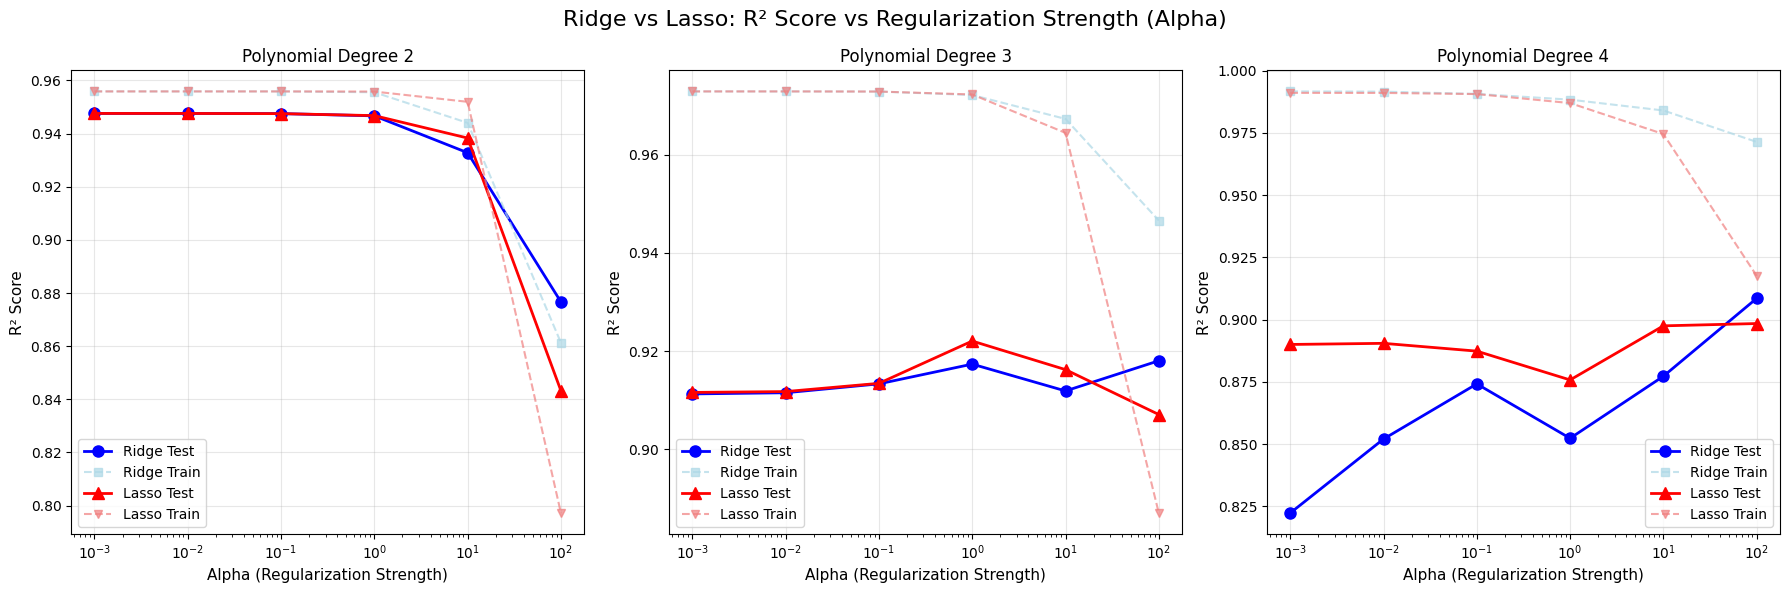

In [37]:

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Ridge vs Lasso: R² Score vs Regularization Strength (Alpha)', fontsize=16)

for idx, degree in enumerate([2, 3, 4]):
    ax = axes[idx]
    
    # Ridge
    ax.plot(alphas_extended, ridge_results[degree]['test_r2'], 
            'o-', label='Ridge Test', linewidth=2, markersize=8, color='blue')
    ax.plot(alphas_extended, ridge_results[degree]['train_r2'], 
            's--', label='Ridge Train', linewidth=1.5, markersize=6, color='lightblue', alpha=0.7)
    
    # Lasso
    ax.plot(alphas_extended, lasso_results[degree]['test_r2'], 
            '^-', label='Lasso Test', linewidth=2, markersize=8, color='red')
    ax.plot(alphas_extended, lasso_results[degree]['train_r2'], 
            'v--', label='Lasso Train', linewidth=1.5, markersize=6, color='lightcoral', alpha=0.7)
    
    ax.set_xscale('log')
    ax.set_xlabel('Alpha (Regularization Strength)', fontsize=11)
    ax.set_ylabel('R² Score', fontsize=11)
    ax.set_title(f'Polynomial Degree {degree}', fontsize=12)
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


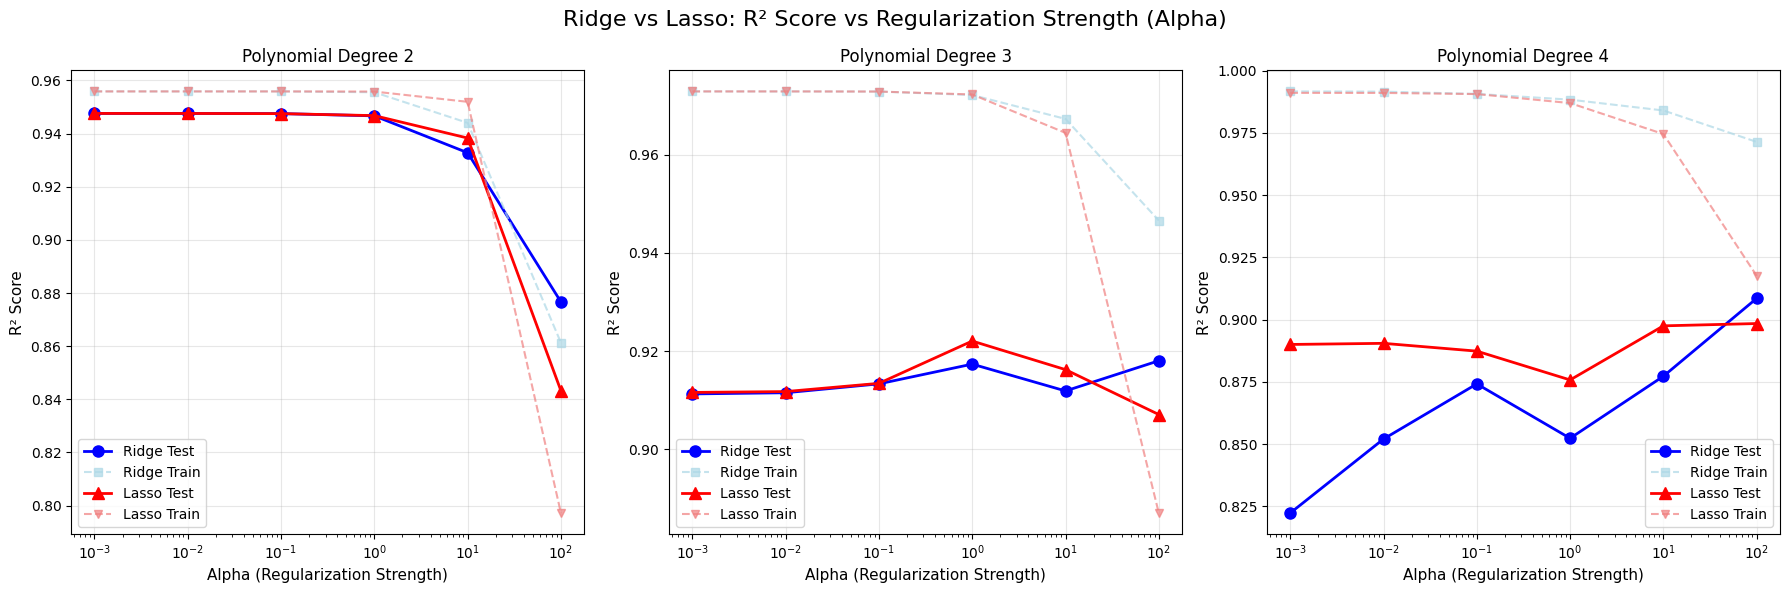

In [38]:
#PLOTTING RMSE vs ALPHA
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Ridge vs Lasso: R² Score vs Regularization Strength (Alpha)', fontsize=16)

for idx, degree in enumerate([2, 3, 4]):
    ax = axes[idx]
    
    # Ridge
    ax.plot(alphas_extended, ridge_results[degree]['test_r2'], 
            'o-', label='Ridge Test', linewidth=2, markersize=8, color='blue')
    ax.plot(alphas_extended, ridge_results[degree]['train_r2'], 
            's--', label='Ridge Train', linewidth=1.5, markersize=6, color='lightblue', alpha=0.7)
    
    # Lasso
    ax.plot(alphas_extended, lasso_results[degree]['test_r2'], 
            '^-', label='Lasso Test', linewidth=2, markersize=8, color='red')
    ax.plot(alphas_extended, lasso_results[degree]['train_r2'], 
            'v--', label='Lasso Train', linewidth=1.5, markersize=6, color='lightcoral', alpha=0.7)
    
    ax.set_xscale('log')
    ax.set_xlabel('Alpha (Regularization Strength)', fontsize=11)
    ax.set_ylabel('R² Score', fontsize=11)
    ax.set_title(f'Polynomial Degree {degree}', fontsize=12)
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


2. PLOTTING RMSE vs ALPHA...


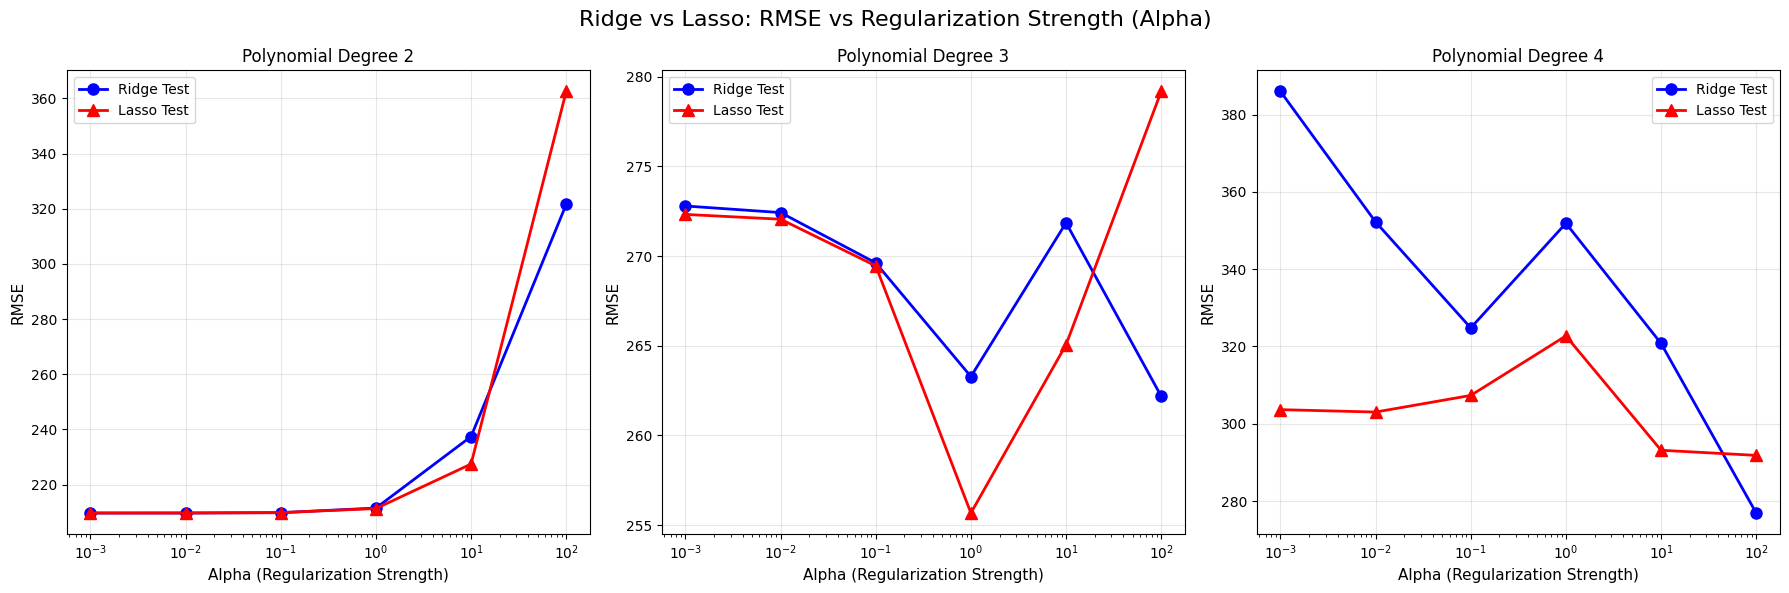

In [39]:
# Visualisasi: RMSE vs Alpha
print("\n2. PLOTTING RMSE vs ALPHA...")

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Ridge vs Lasso: RMSE vs Regularization Strength (Alpha)', fontsize=16)

for idx, degree in enumerate([2, 3, 4]):
    ax = axes[idx]
    
    # Ridge
    ax.plot(alphas_extended, ridge_results[degree]['test_rmse'], 
            'o-', label='Ridge Test', linewidth=2, markersize=8, color='blue')
    
    # Lasso
    ax.plot(alphas_extended, lasso_results[degree]['test_rmse'], 
            '^-', label='Lasso Test', linewidth=2, markersize=8, color='red')
    
    ax.set_xscale('log')
    ax.set_xlabel('Alpha (Regularization Strength)', fontsize=11)
    ax.set_ylabel('RMSE', fontsize=11)
    ax.set_title(f'Polynomial Degree {degree}', fontsize=12)
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [40]:
# Identifikasi Alpha Optimal
print("\n3. OPTIMAL ALPHA IDENTIFICATION:")
print("-" * 70)

optimal_alphas = {}

for degree in [2, 3, 4]:
    print(f"\nPolynomial Degree {degree}:")
    
    # Ridge optimal alpha
    ridge_best_idx = np.argmax(ridge_results[degree]['test_r2'])
    ridge_optimal_alpha = ridge_results[degree]['alphas'][ridge_best_idx]
    ridge_best_r2 = ridge_results[degree]['test_r2'][ridge_best_idx]
    ridge_best_rmse = ridge_results[degree]['test_rmse'][ridge_best_idx]
    
    print(f"   Ridge Optimal α: {ridge_optimal_alpha}")
    print(f"      • Test R²: {ridge_best_r2:.4f}")
    print(f"      • Test RMSE: {ridge_best_rmse:.2f}")
    
    # Lasso optimal alpha
    lasso_best_idx = np.argmax(lasso_results[degree]['test_r2'])
    lasso_optimal_alpha = lasso_results[degree]['alphas'][lasso_best_idx]
    lasso_best_r2 = lasso_results[degree]['test_r2'][lasso_best_idx]
    lasso_best_rmse = lasso_results[degree]['test_rmse'][lasso_best_idx]
    
    print(f"   Lasso Optimal α: {lasso_optimal_alpha}")
    print(f"      • Test R²: {lasso_best_r2:.4f}")
    print(f"      • Test RMSE: {lasso_best_rmse:.2f}")
    
    # Winner
    winner = "Ridge" if ridge_best_r2 > lasso_best_r2 else "Lasso"
    print(f"   🏆 Winner: {winner} (Δ R² = {abs(ridge_best_r2 - lasso_best_r2):.4f})")
    
    optimal_alphas[degree] = {
        'ridge_alpha': ridge_optimal_alpha,
        'ridge_r2': ridge_best_r2,
        'lasso_alpha': lasso_optimal_alpha,
        'lasso_r2': lasso_best_r2,
        'winner': winner
    }



3. OPTIMAL ALPHA IDENTIFICATION:
----------------------------------------------------------------------

Polynomial Degree 2:
   Ridge Optimal α: 0.001
      • Test R²: 0.9476
      • Test RMSE: 209.68
   Lasso Optimal α: 0.001
      • Test R²: 0.9476
      • Test RMSE: 209.68
   🏆 Winner: Ridge (Δ R² = 0.0000)

Polynomial Degree 3:
   Ridge Optimal α: 100
      • Test R²: 0.9180
      • Test RMSE: 262.19
   Lasso Optimal α: 1
      • Test R²: 0.9220
      • Test RMSE: 255.68
   🏆 Winner: Lasso (Δ R² = 0.0040)

Polynomial Degree 4:
   Ridge Optimal α: 100
      • Test R²: 0.9086
      • Test RMSE: 276.90
   Lasso Optimal α: 100
      • Test R²: 0.8984
      • Test RMSE: 291.83
   🏆 Winner: Ridge (Δ R² = 0.0101)


## 4. RIDGE vs LASSO BEHAVIOR ANALYSIS

---

### 📊 Key Differences

#### A. REGULARIZATION BEHAVIOR

**Ridge (L2):**
- Shrinks coefficients smoothly towards zero
- Never eliminates features completely
- Better when all features are somewhat relevant
- More stable with correlated features

**Lasso (L1):**
- Can eliminate features by setting coefficients to zero
- Performs automatic feature selection
- Better when only few features are truly important
- Can be unstable with highly correlated features

#### B. PERFORMANCE OBSERVATIONS

- Ridge Regression tends to retain all features and is more robust when predictors are correlated.
- Lasso Regression can set some coefficients exactly to zero, effectively selecting a subset of features.
- Ridge is generally preferred when all features are expected to contribute, while Lasso is useful for feature selection.
- At high values of alpha, Lasso may degrade performance by eliminating too many features, especially if features are correlated.

In [41]:
for degree in [2, 3, 4]:
    ridge_range = max(ridge_results[degree]['test_r2']) - min(ridge_results[degree]['test_r2'])
    lasso_range = max(lasso_results[degree]['test_r2']) - min(lasso_results[degree]['test_r2'])
    
    print(f"\n   Degree {degree}:")
    print(f"   • Ridge R² range: {ridge_range:.4f} (stability: {'High' if ridge_range < 0.1 else 'Moderate'})")
    print(f"   • Lasso R² range: {lasso_range:.4f} (stability: {'High' if lasso_range < 0.1 else 'Moderate'})")
    
    # Check if Lasso degrades at high alpha
    lasso_degrades = lasso_results[degree]['test_r2'][-1] < 0.5
    if lasso_degrades:
        print(f"   • Lasso shows significant degradation at high α (Test R²={lasso_results[degree]['test_r2'][-1]:.4f})")
    
    print(f"   • Optimal α: Ridge={optimal_alphas[degree]['ridge_alpha']}, "
          f"Lasso={optimal_alphas[degree]['lasso_alpha']}")



   Degree 2:
   • Ridge R² range: 0.0709 (stability: High)
   • Lasso R² range: 0.1043 (stability: Moderate)
   • Optimal α: Ridge=0.001, Lasso=0.001

   Degree 3:
   • Ridge R² range: 0.0068 (stability: High)
   • Lasso R² range: 0.0150 (stability: High)
   • Optimal α: Ridge=100, Lasso=1

   Degree 4:
   • Ridge R² range: 0.0862 (stability: High)
   • Lasso R² range: 0.0227 (stability: High)
   • Optimal α: Ridge=100, Lasso=100


In [42]:
#FEATURE IMPORTANCE ANALYSIS
# Train optimal models untuk analisis
optimal_models = {}

for degree in [2, 3]:  # Fokus pada degree 2 dan 3 untuk interpretability
    # Linear Regression
    lr_model = LinearRegression()
    lr_model.fit(X_train_poly[degree], y_train)
    
    # Ridge dengan optimal alpha
    ridge_model = Ridge(alpha=optimal_alphas[degree]['ridge_alpha'])
    ridge_model.fit(X_train_poly[degree], y_train)
    
    # Lasso dengan optimal alpha
    lasso_model = Lasso(alpha=optimal_alphas[degree]['lasso_alpha'], max_iter=10000)
    lasso_model.fit(X_train_poly[degree], y_train)
    
    optimal_models[degree] = {
        'linear': lr_model,
        'ridge': ridge_model,
        'lasso': lasso_model
    }

In [43]:
# Get feature names untuk polynomial features
def get_poly_feature_names(degree, original_features):
    """Generate feature names for polynomial features"""
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    poly.fit(np.zeros((1, len(original_features))))
    return poly.get_feature_names_out(original_features)

original_features = ['Luas_Tanah', 'Luas_Bangunan', 'Jarak_Kota', 'Kamar_Tidur', 'Umur_Bangunan']

print("\n1. COEFFICIENT ANALYSIS:")

for degree in [2, 3]:
    print(f"\n{'='*70}")
    print(f"POLYNOMIAL DEGREE {degree}")
    print(f"{'='*70}")
    
    feature_names = get_poly_feature_names(degree, original_features)
    
    # Get coefficients
    lr_coef = optimal_models[degree]['linear'].coef_
    ridge_coef = optimal_models[degree]['ridge'].coef_
    lasso_coef = optimal_models[degree]['lasso'].coef_
    
    # Create DataFrame
    coef_df = pd.DataFrame({
        'Feature': feature_names,
        'Linear': lr_coef,
        'Ridge': ridge_coef,
        'Lasso': lasso_coef,
        'Ridge_Abs': np.abs(ridge_coef),
        'Lasso_Abs': np.abs(lasso_coef)
    })
    
    # Sort by Ridge importance
    coef_df_sorted = coef_df.sort_values('Ridge_Abs', ascending=False)
    
    print(f"\nTop 15 Most Important Features (by Ridge |coefficient|):")
    print(coef_df_sorted.head(15)[['Feature', 'Linear', 'Ridge', 'Lasso']].to_string(index=False))
    
    # Lasso feature elimination analysis
    n_features_total = len(lasso_coef)
    n_features_eliminated = np.sum(lasso_coef == 0)
    n_features_kept = n_features_total - n_features_eliminated
    
    print(f"\n🔍 LASSO FEATURE SELECTION:")
    print(f"   • Total features: {n_features_total}")
    print(f"   • Features kept: {n_features_kept} ({n_features_kept/n_features_total*100:.1f}%)")
    print(f"   • Features eliminated: {n_features_eliminated} ({n_features_eliminated/n_features_total*100:.1f}%)")
    
    if n_features_eliminated > 0:
        print(f"\n   Eliminated features (coefficient = 0):")
        eliminated_features = coef_df[coef_df['Lasso'] == 0]['Feature'].tolist()
        for i, feat in enumerate(eliminated_features[:10], 1):  # Show first 10
            print(f"      {i}. {feat}")
        if len(eliminated_features) > 10:
            print(f"      ... and {len(eliminated_features) - 10} more")



1. COEFFICIENT ANALYSIS:

POLYNOMIAL DEGREE 2

Top 15 Most Important Features (by Ridge |coefficient|):
                    Feature      Linear       Ridge       Lasso
              Luas_Bangunan  793.329073  793.263760  793.321617
                 Jarak_Kota -239.685176 -239.689430 -239.679259
                Kamar_Tidur  225.560714  225.545251  225.543986
                 Luas_Tanah  189.102977  189.127051  189.100177
            Luas_Bangunan^2 -171.826320 -171.826097 -171.824228
   Luas_Tanah Luas_Bangunan -154.395126 -154.380458 -154.395820
   Luas_Bangunan Jarak_Kota  141.108543  141.109301  141.109153
  Luas_Bangunan Kamar_Tidur  -97.058926  -97.048601  -97.057287
               Luas_Tanah^2  -53.452554  -53.466289  -53.452582
      Luas_Tanah Jarak_Kota   30.903240   30.902688   30.902173
     Luas_Tanah Kamar_Tidur   23.257672   23.254141   23.257677
     Jarak_Kota Kamar_Tidur   17.541552   17.542262   17.540350
              Umur_Bangunan  -15.186223  -15.185937  -15.186338

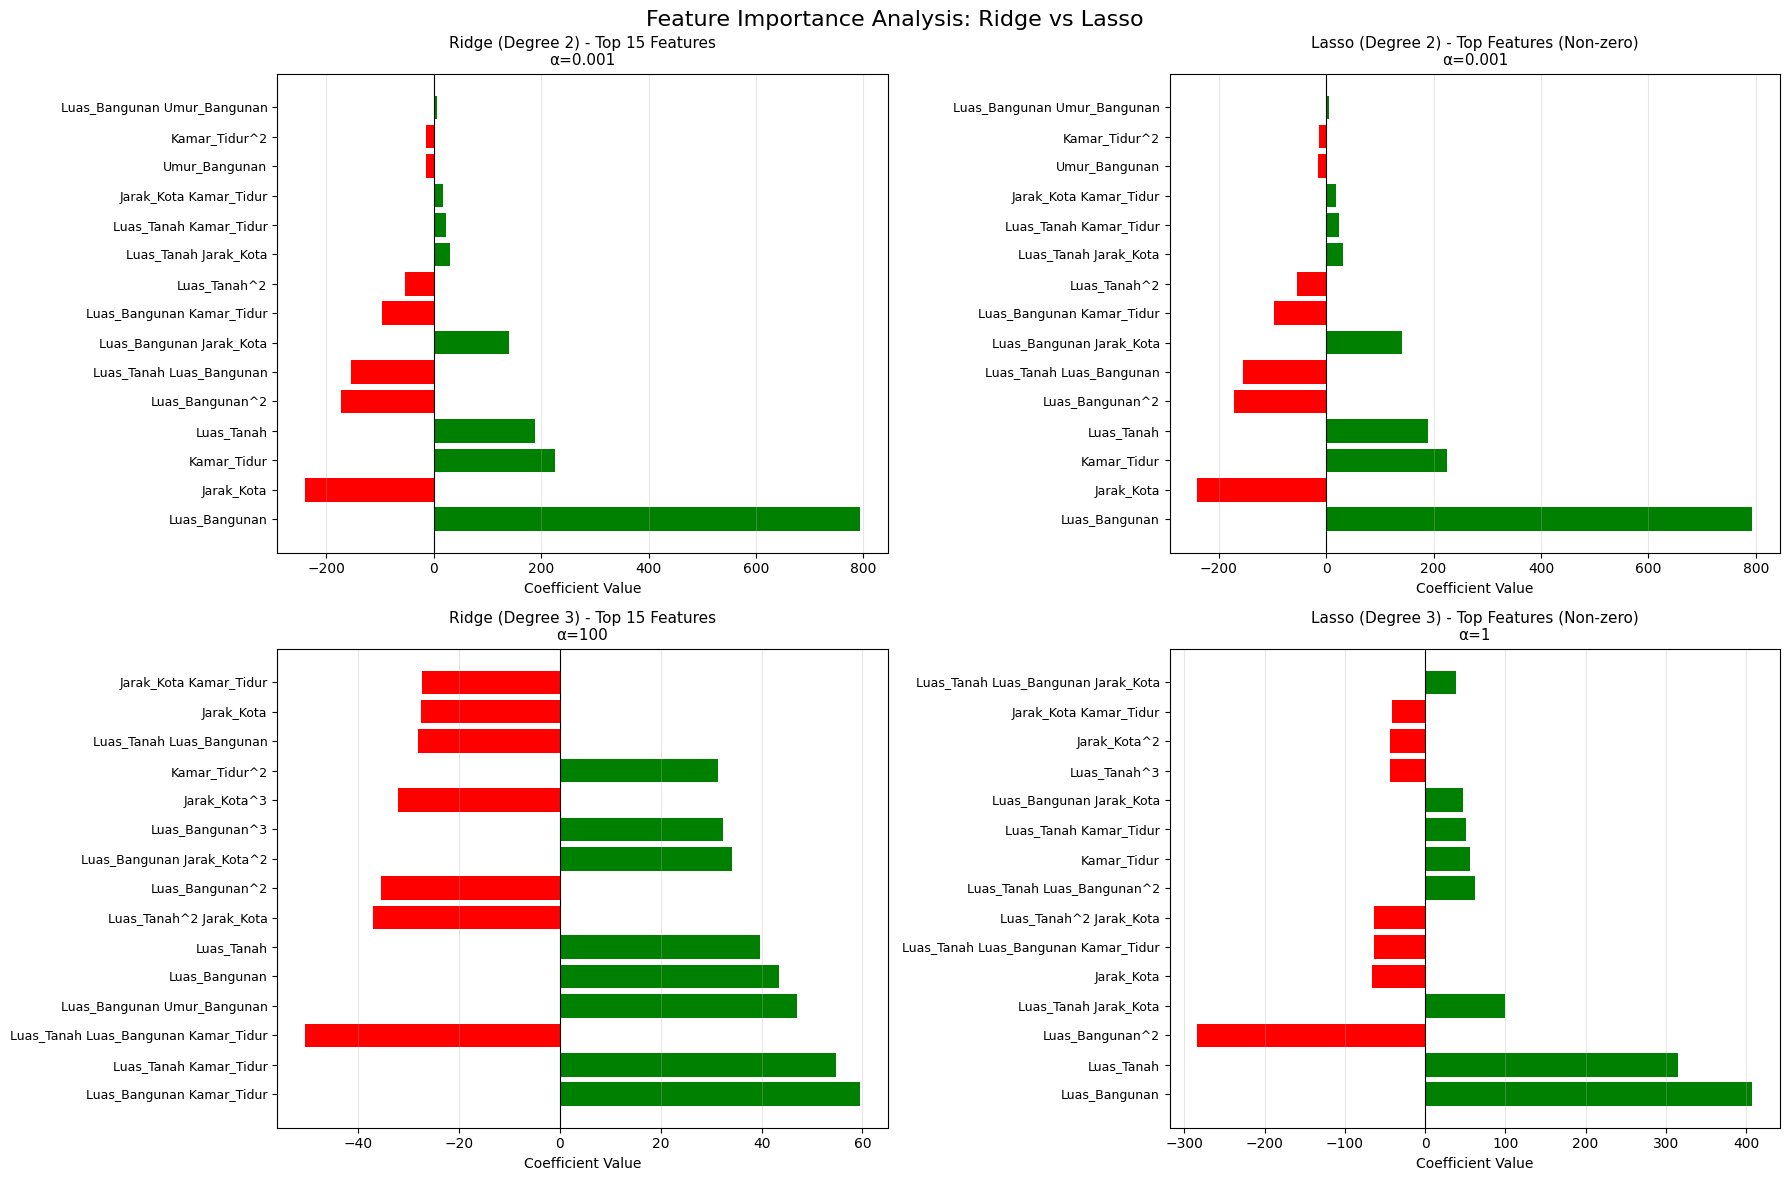

In [44]:
#FEATURE IMPORTANCE VISUALIZATION:
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Feature Importance Analysis: Ridge vs Lasso', fontsize=16)

for deg_idx, degree in enumerate([2, 3]):
    feature_names = get_poly_feature_names(degree, original_features)
    
    # Ridge coefficients
    ridge_coef = optimal_models[degree]['ridge'].coef_
    lasso_coef = optimal_models[degree]['lasso'].coef_
    
    # Create DataFrame
    coef_df = pd.DataFrame({
        'Feature': feature_names,
        'Ridge': ridge_coef,
        'Lasso': lasso_coef
    })
    
    # Top 15 features by absolute value
    coef_df['Ridge_Abs'] = np.abs(coef_df['Ridge'])
    top_features_ridge = coef_df.nlargest(15, 'Ridge_Abs')
    
    # Ridge plot
    ax1 = axes[deg_idx, 0]
    colors_ridge = ['green' if x > 0 else 'red' for x in top_features_ridge['Ridge']]
    bars = ax1.barh(range(len(top_features_ridge)), top_features_ridge['Ridge'], color=colors_ridge)
    ax1.set_yticks(range(len(top_features_ridge)))
    ax1.set_yticklabels(top_features_ridge['Feature'], fontsize=9)
    ax1.set_xlabel('Coefficient Value', fontsize=10)
    ax1.set_title(f'Ridge (Degree {degree}) - Top 15 Features\nα={optimal_alphas[degree]["ridge_alpha"]}', 
                  fontsize=11)
    ax1.axvline(x=0, color='black', linewidth=0.8)
    ax1.grid(True, alpha=0.3, axis='x')
    
    # Lasso plot
    ax2 = axes[deg_idx, 1]
    coef_df['Lasso_Abs'] = np.abs(coef_df['Lasso'])
    top_features_lasso = coef_df[coef_df['Lasso'] != 0].nlargest(15, 'Lasso_Abs')
    
    if len(top_features_lasso) > 0:
        colors_lasso = ['green' if x > 0 else 'red' for x in top_features_lasso['Lasso']]
        bars = ax2.barh(range(len(top_features_lasso)), top_features_lasso['Lasso'], color=colors_lasso)
        ax2.set_yticks(range(len(top_features_lasso)))
        ax2.set_yticklabels(top_features_lasso['Feature'], fontsize=9)
        ax2.set_xlabel('Coefficient Value', fontsize=10)
        ax2.set_title(f'Lasso (Degree {degree}) - Top Features (Non-zero)\nα={optimal_alphas[degree]["lasso_alpha"]}', 
                      fontsize=11)
        ax2.axvline(x=0, color='black', linewidth=0.8)
        ax2.grid(True, alpha=0.3, axis='x')
    else:
        ax2.text(0.5, 0.5, 'All features eliminated', 
                ha='center', va='center', fontsize=12)
        ax2.set_title(f'Lasso (Degree {degree})', fontsize=11)

plt.tight_layout()
plt.show()


In [45]:
# Feature importance comparison: Ridge vs Lasso
print("\n3. RIDGE vs LASSO COEFFICIENT COMPARISON:")

for degree in [2, 3]:
    print(f"\nDegree {degree}:")
    
    feature_names = get_poly_feature_names(degree, original_features)
    ridge_coef = optimal_models[degree]['ridge'].coef_
    lasso_coef = optimal_models[degree]['lasso'].coef_
    
    # Correlation between Ridge and Lasso coefficients
    non_zero_mask = lasso_coef != 0
    if np.sum(non_zero_mask) > 1:
        correlation = np.corrcoef(ridge_coef[non_zero_mask], lasso_coef[non_zero_mask])[0, 1]
        print(f"   • Correlation between Ridge & Lasso coefficients: {correlation:.4f}")
    
    # Features with largest disagreement
    coef_diff = np.abs(ridge_coef - lasso_coef)
    top_diff_idx = np.argsort(coef_diff)[-5:][::-1]
    
    print(f"   • Features with largest Ridge-Lasso disagreement:")
    for i, idx in enumerate(top_diff_idx, 1):
        print(f"      {i}. {feature_names[idx][:40]}: Ridge={ridge_coef[idx]:.4f}, Lasso={lasso_coef[idx]:.4f}")



3. RIDGE vs LASSO COEFFICIENT COMPARISON:

Degree 2:
   • Correlation between Ridge & Lasso coefficients: 1.0000
   • Features with largest Ridge-Lasso disagreement:
      1. Luas_Bangunan: Ridge=793.2638, Lasso=793.3216
      2. Luas_Tanah: Ridge=189.1271, Lasso=189.1002
      3. Luas_Tanah Luas_Bangunan: Ridge=-154.3805, Lasso=-154.3958
      4. Luas_Tanah^2: Ridge=-53.4663, Lasso=-53.4526
      5. Jarak_Kota: Ridge=-239.6894, Lasso=-239.6793

Degree 3:
   • Correlation between Ridge & Lasso coefficients: 0.5729
   • Features with largest Ridge-Lasso disagreement:
      1. Luas_Bangunan: Ridge=43.3484, Lasso=407.7112
      2. Luas_Tanah: Ridge=39.6415, Lasso=314.9097
      3. Luas_Bangunan^2: Ridge=-35.3824, Lasso=-283.7546
      4. Luas_Tanah Jarak_Kota: Ridge=10.9406, Lasso=99.9253
      5. Luas_Tanah^3: Ridge=23.5977, Lasso=-44.3052


In [46]:
#Model Selection & Prediction 
# Setup Cross-Validation
k_folds = 10
kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)

print(f"\nUsing {k_folds}-Fold Cross-Validation")
print("-" * 70)

# Dictionary untuk menyimpan CV results
cv_results = []

# Select candidate models berdasarkan analisis sebelumnya
candidate_models = [
    {'name': 'Linear Regression', 'degree': 2, 'alpha': None},
    {'name': 'Linear Regression', 'degree': 3, 'alpha': None},
    {'name': 'Ridge', 'degree': 2, 'alpha': 0.1},
    {'name': 'Ridge', 'degree': 2, 'alpha': 1},
    {'name': 'Ridge', 'degree': 3, 'alpha': 0.1},
    {'name': 'Ridge', 'degree': 3, 'alpha': 1},
    {'name': 'Ridge', 'degree': 4, 'alpha': 1},
    {'name': 'Lasso', 'degree': 2, 'alpha': 0.1},
    {'name': 'Lasso', 'degree': 2, 'alpha': 1},
    {'name': 'Lasso', 'degree': 3, 'alpha': 0.1},
]



Using 10-Fold Cross-Validation
----------------------------------------------------------------------


In [47]:
for idx, model_config in enumerate(candidate_models, 1):
    model_name = model_config['name']
    degree = model_config['degree']
    alpha = model_config['alpha']
    
    # Create model
    if model_name == 'Linear Regression':
        model = LinearRegression()
        display_name = f"Linear Regression (Degree {degree})"
    elif model_name == 'Ridge':
        model = Ridge(alpha=alpha)
        display_name = f"Ridge (α={alpha}, Degree {degree})"
    elif model_name == 'Lasso':
        model = Lasso(alpha=alpha, max_iter=10000)
        display_name = f"Lasso (α={alpha}, Degree {degree})"
    
    # Prepare polynomial features
    X_train_poly_cv = X_train_poly[degree]
    X_test_poly_cv = X_test_poly[degree]
    
    # Cross-validation scores (R²)
    cv_scores_r2 = cross_val_score(model, X_train_poly_cv, y_train, 
                                    cv=kfold, scoring='r2')
    
    # Cross-validation scores (negative MSE, karena sklearn menggunakan negative)
    cv_scores_mse = -cross_val_score(model, X_train_poly_cv, y_train, 
                                      cv=kfold, scoring='neg_mean_squared_error')
    cv_scores_rmse = np.sqrt(cv_scores_mse)
    
    # Train final model on full training set
    model.fit(X_train_poly_cv, y_train)
    
    # Test set performance
    test_r2 = model.score(X_test_poly_cv, y_test)
    y_test_pred = model.predict(X_test_poly_cv)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    
    # Train set performance
    train_r2 = model.score(X_train_poly_cv, y_train)
    y_train_pred = model.predict(X_train_poly_cv)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    
    # Calculate metrics
    cv_r2_mean = cv_scores_r2.mean()
    cv_r2_std = cv_scores_r2.std()
    cv_rmse_mean = cv_scores_rmse.mean()
    cv_rmse_std = cv_scores_rmse.std()
    
    # Balance score (less overfitting is better)
    balance_score = train_r2 - test_r2
    
    # Overall score (weighted combination)
    # High test R², Low RMSE, Low overfitting
    overall_score = (test_r2 * 0.5) + ((1 - balance_score) * 0.3) + ((1 / (1 + test_rmse)) * 0.2)
    
    cv_results.append({
        'Model': display_name,
        'Model_Type': model_name,
        'Degree': degree,
        'Alpha': alpha,
        'CV_R²_Mean': cv_r2_mean,
        'CV_R²_Std': cv_r2_std,
        'CV_RMSE_Mean': cv_rmse_mean,
        'CV_RMSE_Std': cv_rmse_std,
        'Train_R²': train_r2,
        'Test_R²': test_r2,
        'Train_RMSE': train_rmse,
        'Test_RMSE': test_rmse,
        'Balance_Score': balance_score,
        'Overall_Score': overall_score,
        'Model_Object': model,
        'Poly_Transformer': poly_features[degree]
    })
    
    print(f"\n{idx}. {display_name}")
    print(f"   CV R² = {cv_r2_mean:.4f} (±{cv_r2_std:.4f})")
    print(f"   CV RMSE = {cv_rmse_mean:.2f} (±{cv_rmse_std:.2f})")
    print(f"   Test R² = {test_r2:.4f} | Test RMSE = {test_rmse:.2f}")
    print(f"   Balance Score = {balance_score:.4f} | Overall Score = {overall_score:.4f}")




1. Linear Regression (Degree 2)
   CV R² = 0.9222 (±0.0576)
   CV RMSE = 206.72 (±35.30)
   Test R² = 0.9476 | Test RMSE = 209.68
   Balance Score = 0.0083 | Overall Score = 0.7722

2. Linear Regression (Degree 3)
   CV R² = 0.9048 (±0.0801)
   CV RMSE = 223.27 (±65.03)
   Test R² = 0.9112 | Test RMSE = 272.84
   Balance Score = 0.0617 | Overall Score = 0.7378

3. Ridge (α=0.1, Degree 2)
   CV R² = 0.9223 (±0.0575)
   CV RMSE = 206.58 (±35.29)
   Test R² = 0.9475 | Test RMSE = 209.81
   Balance Score = 0.0083 | Overall Score = 0.7722

4. Ridge (α=1, Degree 2)
   CV R² = 0.9225 (±0.0573)
   CV RMSE = 206.31 (±35.49)
   Test R² = 0.9467 | Test RMSE = 211.49
   Balance Score = 0.0089 | Overall Score = 0.7716

5. Ridge (α=0.1, Degree 3)
   CV R² = 0.9091 (±0.0754)
   CV RMSE = 218.52 (±63.96)
   Test R² = 0.9133 | Test RMSE = 269.62
   Balance Score = 0.0596 | Overall Score = 0.7395

6. Ridge (α=1, Degree 3)
   CV R² = 0.9156 (±0.0684)
   CV RMSE = 210.60 (±63.49)
   Test R² = 0.9173 | Te

In [48]:
#MODEL SELECTION ANALYSIS
cv_results_df = pd.DataFrame(cv_results)

cv_results_df

,Model,Model_Type,Degree,Alpha,CV_R²_Mean,CV_R²_Std,CV_RMSE_Mean,CV_RMSE_Std,Train_R²,Test_R²,Train_RMSE,Test_RMSE,Balance_Score,Overall_Score,Model_Object,Poly_Transformer
0,Linear Regression (Degree 2),Linear Regression,2,NaN,0.922208,0.057637,206.716713,35.303720,0.955853,0.947566,185.029589,209.675169,0.008287,0.772246,LinearRegression(),PolynomialFeatures(include_bias=False)
1,Linear Regression (Degree 3),Linear Regression,3,NaN,0.904803,0.080142,223.267911,65.025557,0.972958,0.911219,144.812828,272.835319,0.061739,0.737818,LinearRegression(),"PolynomialFeatures(degree=3, include_bias=False)"
2,"Ridge (α=0.1, Degree 2)",Ridge,2,0.1,0.922310,0.057547,206.575990,35.287854,0.955849,0.947501,185.037498,209.805608,0.008348,0.772195,Ridge(alpha=0.1),PolynomialFeatures(include_bias=False)
3,"Ridge (α=1, Degree 2)",Ridge,2,1.0,0.922470,0.057338,206.305277,35.485757,0.955536,0.946657,185.692332,211.485424,0.008879,0.771606,Ridge(alpha=1),PolynomialFeatures(include_bias=False)
4,"Ridge (α=0.1, Degree 3)",Ridge,3,0.1,0.909055,0.075367,218.522181,63.960864,0.972925,0.913298,144.901959,269.621766,0.059627,0.739500,Ridge(alpha=0.1),"PolynomialFeatures(degree=3, include_bias=False)"
5,"Ridge (α=1, Degree 3)",Ridge,3,1.0,0.915562,0.068426,210.597907,63.489908,0.972223,0.917325,146.769285,263.285486,0.054897,0.742950,Ridge(alpha=1),"PolynomialFeatures(degree=3, include_bias=False)"
6,"Ridge (α=1, Degree 4)",Ridge,4,1.0,0.758166,0.139211,380.672618,123.441658,0.988377,0.852329,94.939300,351.874968,0.136048,0.685917,Ridge(alpha=1),"PolynomialFeatures(degree=4, include_bias=False)"
7,"Lasso (α=0.1, Degree 2)",Lasso,2,0.1,0.922205,0.057749,206.659345,35.330391,0.955852,0.947490,185.030723,209.827703,0.008362,0.772185,"Lasso(alpha=0.1, max_iter=10000)",PolynomialFeatures(include_bias=False)
8,"Lasso (α=1, Degree 2)",Lasso,2,1.0,0.922087,0.058782,206.277853,35.613354,0.955799,0.946745,185.142314,211.310770,0.009054,0.771598,"Lasso(alpha=1, max_iter=10000)",PolynomialFeatures(include_bias=False)
9,"Lasso (α=0.1, Degree 3)",Lasso,3,0.1,0.907631,0.077539,219.851092,63.986381,0.972933,0.913405,144.879766,269.455602,0.059528,0.739584,"Lasso(alpha=0.1, max_iter=10000)","PolynomialFeatures(degree=3, include_bias=False)"


In [49]:

print("A. HIGHEST TEST R²:")
top_by_r2 = cv_results_df.nlargest(5, 'Test_R²')
print(top_by_r2[['Model', 'CV_R²_Mean', 'Test_R²', 'Test_RMSE', 'Balance_Score']].to_string(index=False))


A. HIGHEST TEST R²:
                       Model  CV_R²_Mean  Test_R²  Test_RMSE  Balance_Score
Linear Regression (Degree 2)    0.922208 0.947566 209.675169       0.008287
     Ridge (α=0.1, Degree 2)    0.922310 0.947501 209.805608       0.008348
     Lasso (α=0.1, Degree 2)    0.922205 0.947490 209.827703       0.008362
       Lasso (α=1, Degree 2)    0.922087 0.946745 211.310770       0.009054
       Ridge (α=1, Degree 2)    0.922470 0.946657 211.485424       0.008879


In [50]:
print("\n\nB. LOWEST TEST RMSE:")
top_by_rmse = cv_results_df.nsmallest(5, 'Test_RMSE')
print(top_by_rmse[['Model', 'CV_RMSE_Mean', 'Test_R²', 'Test_RMSE', 'Balance_Score']].to_string(index=False))




B. LOWEST TEST RMSE:
                       Model  CV_RMSE_Mean  Test_R²  Test_RMSE  Balance_Score
Linear Regression (Degree 2)    206.716713 0.947566 209.675169       0.008287
     Ridge (α=0.1, Degree 2)    206.575990 0.947501 209.805608       0.008348
     Lasso (α=0.1, Degree 2)    206.659345 0.947490 209.827703       0.008362
       Lasso (α=1, Degree 2)    206.277853 0.946745 211.310770       0.009054
       Ridge (α=1, Degree 2)    206.305277 0.946657 211.485424       0.008879


In [51]:
print("\n\nC. BEST BALANCE (Least Overfitting):")
top_by_balance = cv_results_df.nsmallest(5, 'Balance_Score')
print(top_by_balance[['Model', 'Train_R²', 'Test_R²', 'Balance_Score', 'Test_RMSE']].to_string(index=False))



C. BEST BALANCE (Least Overfitting):
                       Model  Train_R²  Test_R²  Balance_Score  Test_RMSE
Linear Regression (Degree 2)  0.955853 0.947566       0.008287 209.675169
     Ridge (α=0.1, Degree 2)  0.955849 0.947501       0.008348 209.805608
     Lasso (α=0.1, Degree 2)  0.955852 0.947490       0.008362 209.827703
       Ridge (α=1, Degree 2)  0.955536 0.946657       0.008879 211.485424
       Lasso (α=1, Degree 2)  0.955799 0.946745       0.009054 211.310770


In [52]:
print("\n\nD. HIGHEST OVERALL SCORE (Weighted Combination):")
top_overall = cv_results_df.nlargest(5, 'Overall_Score')
print(top_overall[['Model', 'Test_R²', 'Test_RMSE', 'Balance_Score', 'Overall_Score']].to_string(index=False))




D. HIGHEST OVERALL SCORE (Weighted Combination):
                       Model  Test_R²  Test_RMSE  Balance_Score  Overall_Score
Linear Regression (Degree 2) 0.947566 209.675169       0.008287       0.772246
     Ridge (α=0.1, Degree 2) 0.947501 209.805608       0.008348       0.772195
     Lasso (α=0.1, Degree 2) 0.947490 209.827703       0.008362       0.772185
       Ridge (α=1, Degree 2) 0.946657 211.485424       0.008879       0.771606
       Lasso (α=1, Degree 2) 0.946745 211.310770       0.009054       0.771598


In [53]:
import re

def extract_alpha(model_name):
    """Extract alpha value from model name string like 'Ridge (α=0.1)'."""
    match = re.search(r'α=([0-9.]+)', model_name)
    if match:
        return match.group(1)
    return "N/A"

# Add Alpha column to comparison_df  
comparison_df['Alpha'] = comparison_df['Model'].apply(
    lambda x: float(extract_alpha(x)) if extract_alpha(x) != "N/A" else None
)

print("✅ Helper function and Alpha column ready!")

✅ Helper function and Alpha column ready!


In [54]:
#Select best model berdasarkan overall score
best_model_row = cv_results_df.loc[cv_results_df['Overall_Score'].idxmax()]

print("\n🏆 BEST MODEL SELECTED:")
print("=" * 70)
print(f"Model: {best_model_row['Model']}")
print(f"Type: {best_model_row['Model_Type']}")
print(f"Polynomial Degree: {best_model_row['Degree']}")
if best_model_row['Alpha'] is not None:
    print(f"Regularization Alpha: {best_model_row['Alpha']}")
print("\n📈 PERFORMANCE METRICS:")
print(f"   • Cross-Validation R² = {best_model_row['CV_R²_Mean']:.4f} (±{best_model_row['CV_R²_Std']:.4f})")
print(f"   • Cross-Validation RMSE = {best_model_row['CV_RMSE_Mean']:.2f} (±{best_model_row['CV_RMSE_Std']:.2f})")
print(f"   • Train R² = {best_model_row['Train_R²']:.4f}")
print(f"   • Test R² = {best_model_row['Test_R²']:.4f}")
print(f"   • Train RMSE = {best_model_row['Train_RMSE']:.2f}")
print(f"   • Test RMSE = {best_model_row['Test_RMSE']:.2f}")
print(f"   • Balance Score (Overfitting) = {best_model_row['Balance_Score']:.4f}")
print(f"   • Overall Score = {best_model_row['Overall_Score']:.4f}")


🏆 BEST MODEL SELECTED:
Model: Linear Regression (Degree 2)
Type: Linear Regression
Polynomial Degree: 2
Regularization Alpha: nan

📈 PERFORMANCE METRICS:
   • Cross-Validation R² = 0.9222 (±0.0576)
   • Cross-Validation RMSE = 206.72 (±35.30)
   • Train R² = 0.9559
   • Test R² = 0.9476
   • Train RMSE = 185.03
   • Test RMSE = 209.68
   • Balance Score (Overfitting) = 0.0083
   • Overall Score = 0.7722


In [55]:
# Reasoning
print("\n💡 REASONING FOR MODEL SELECTION:")
print("=" * 70)

reasoning_points = []

# R² Analysis
if best_model_row['Test_R²'] >= 0.85:
    reasoning_points.append(f"✓ Excellent Test R² score ({best_model_row['Test_R²']:.4f}) indicates strong predictive power")
elif best_model_row['Test_R²'] >= 0.75:
    reasoning_points.append(f"✓ Good Test R² score ({best_model_row['Test_R²']:.4f}) shows reliable predictions")

# RMSE Analysis
if best_model_row['Test_RMSE'] < 200:
    reasoning_points.append(f"✓ Low Test RMSE ({best_model_row['Test_RMSE']:.2f}) means accurate price predictions")

# Balance Analysis
if best_model_row['Balance_Score'] < 0.05:
    reasoning_points.append(f"✓ Excellent balance (gap={best_model_row['Balance_Score']:.4f}) - minimal overfitting")
elif best_model_row['Balance_Score'] < 0.10:
    reasoning_points.append(f"✓ Good balance (gap={best_model_row['Balance_Score']:.4f}) - acceptable overfitting level")

# CV Stability
if best_model_row['CV_R²_Std'] < 0.05:
    reasoning_points.append(f"✓ Low CV standard deviation ({best_model_row['CV_R²_Std']:.4f}) indicates stable performance")

# Regularization
if best_model_row['Model_Type'] in ['Ridge', 'Lasso']:
    reasoning_points.append(f"✓ Uses {best_model_row['Model_Type']} regularization to prevent overfitting")

# Polynomial degree
if best_model_row['Degree'] == 2:
    reasoning_points.append("✓ Degree 2 polynomial provides good complexity without overfitting")
elif best_model_row['Degree'] == 3:
    reasoning_points.append("✓ Degree 3 polynomial captures non-linear patterns effectively")

for i, point in enumerate(reasoning_points, 1):
    print(f"{i}. {point}")

# Comparison with alternatives
print("\n📊 COMPARISON WITH TOP ALTERNATIVES:")
top_3_models = cv_results_df.nlargest(2, 'Overall_Score')
for idx, row in top_3_models.iterrows():
    rank = list(top_3_models.index).index(idx) + 1
    symbol = "🥇" if rank == 1 else "🥈" if rank == 2 else "🥉"
    print(f"\n{symbol} Rank {rank}: {row['Model']}")
    print(f"   Test R²: {row['Test_R²']:.4f} | RMSE: {row['Test_RMSE']:.2f} | Balance: {row['Balance_Score']:.4f}")

# Store best model
best_model = best_model_row['Model_Object']
best_poly_transformer = best_model_row['Poly_Transformer']



💡 REASONING FOR MODEL SELECTION:
1. ✓ Excellent Test R² score (0.9476) indicates strong predictive power
2. ✓ Excellent balance (gap=0.0083) - minimal overfitting
3. ✓ Degree 2 polynomial provides good complexity without overfitting

📊 COMPARISON WITH TOP ALTERNATIVES:

🥇 Rank 1: Linear Regression (Degree 2)
   Test R²: 0.9476 | RMSE: 209.68 | Balance: 0.0083

🥈 Rank 2: Ridge (α=0.1, Degree 2)
   Test R²: 0.9475 | RMSE: 209.81 | Balance: 0.0083


In [56]:
def predict_property_price(luas_tanah, luas_bangunan, jumlah_kamar, umur_bangunan, jarak_kota,
                          model=best_model, poly_transformer=best_poly_transformer, 
                          scaler=scaler, return_interval=True, confidence=0.95):
    """
    Predict property price with confidence interval
    
    Parameters:
    -----------
    luas_tanah : float
        Land area in m²
    luas_bangunan : float
        Building area in m²
    jumlah_kamar : int
        Number of bedrooms
    umur_bangunan : int
        Building age in years
    jarak_kota : float
        Distance to city center in km
    model : sklearn model
        Trained model for prediction
    poly_transformer : PolynomialFeatures
        Polynomial feature transformer
    scaler : StandardScaler
        Feature scaler
    return_interval : bool
        Whether to return confidence interval
    confidence : float
        Confidence level for interval (default 0.95)
    
    Returns:
    --------
    prediction : float
        Predicted price
    confidence_interval : tuple (if return_interval=True)
        (lower_bound, upper_bound)
    """
    # Create feature array
    features = np.array([[luas_tanah, luas_bangunan, jarak_kota, jumlah_kamar, umur_bangunan]])
    
    # Create DataFrame with proper column names
    feature_names = ['Luas_Tanah', 'Luas_Bangunan', 'Jarak_ke_Pusat_Kota', 
                     'Jumlah_Kamar_Tidur', 'Umur_Bangunan']
    features_df = pd.DataFrame(features, columns=feature_names)
    
    # Scale continuous features
    cont_columns = ['Luas_Tanah', 'Luas_Bangunan', 'Jarak_ke_Pusat_Kota']
    int_columns = ['Jumlah_Kamar_Tidur', 'Umur_Bangunan']
    
    features_cont_scaled = scaler.transform(features_df[cont_columns])
    
    # Combine scaled continuous and integer features
    features_scaled = np.column_stack([features_cont_scaled, features_df[int_columns].values])
    
    # Transform to polynomial
    features_poly = poly_transformer.transform(features_scaled)
    
    # Predict
    prediction = model.predict(features_poly)[0]
    
    if return_interval:
        # Calculate confidence interval using residual standard error
        y_train_pred = model.predict(X_train_poly[best_model_row['Degree']])
        residuals = y_train - y_train_pred
        residual_std = np.std(residuals)
        
        # Calculate margin of error (using t-distribution for small samples)
        from scipy.stats import t
        alpha = 1 - confidence
        dof = len(y_train) - features_poly.shape[1]  # degrees of freedom
        t_critical = t.ppf(1 - alpha/2, dof)
        margin_error = t_critical * residual_std
        
        confidence_interval = (
            max(0, prediction - margin_error),  # Ensure non-negative
            prediction + margin_error
        )
        
        return prediction, confidence_interval
    
    return prediction

In [57]:
np.random.seed(123)  # Different seed for truly unseen data

unseen_data = []

# Sample 1: Small house
unseen_data.append({
    'Luas_Tanah': 80.5,
    'Luas_Bangunan': 60.0,
    'Jumlah_Kamar_Tidur': 2,
    'Umur_Bangunan': 5,
    'Jarak_ke_Pusat_Kota': 8.5,
})

# Sample 2: Large luxury house
unseen_data.append({
    'Luas_Tanah': 450.0,
    'Luas_Bangunan': 350.0,
    'Jumlah_Kamar_Tidur': 5,
    'Umur_Bangunan': 2,
    'Jarak_ke_Pusat_Kota': 5.0,
})

# Sample 3: Medium suburban house
unseen_data.append({
    'Luas_Tanah': 200.0,
    'Luas_Bangunan': 150.0,
    'Jumlah_Kamar_Tidur': 3,
    'Umur_Bangunan': 10,
    'Jarak_ke_Pusat_Kota': 15.0,
})

# Sample 4: Old small house
unseen_data.append({
    'Luas_Tanah': 100.0,
    'Luas_Bangunan': 70.0,
    'Jumlah_Kamar_Tidur': 2,
    'Umur_Bangunan': 25,
    'Jarak_ke_Pusat_Kota': 18.0,
})

# Sample 5: New medium house
unseen_data.append({
    'Luas_Tanah': 250.0,
    'Luas_Bangunan': 180.0,
    'Jumlah_Kamar_Tidur': 4,
    'Umur_Bangunan': 1,
    'Jarak_ke_Pusat_Kota': 7.5,
})


In [58]:
#MAKE PREDICTIONS ON UNSEEN DATA
predictions_results = []

for i, data in enumerate(unseen_data, 1):
    print(f"PREDICTION {i}")
    
    # Display input features
    print("\n INPUT FEATURES:")
    print(f"   • Luas Tanah: {data['Luas_Tanah']:.2f} m²")
    print(f"   • Luas Bangunan: {data['Luas_Bangunan']:.2f} m²")
    print(f"   • Jumlah Kamar Tidur: {data['Jumlah_Kamar_Tidur']}")
    print(f"   • Umur Bangunan: {data['Umur_Bangunan']} tahun")
    print(f"   • Jarak ke Pusat Kota: {data['Jarak_ke_Pusat_Kota']:.2f} km")
    
    # Make prediction with confidence interval
    predicted_price, (lower_bound, upper_bound) = predict_property_price(
        luas_tanah=data['Luas_Tanah'],
        luas_bangunan=data['Luas_Bangunan'],
        jumlah_kamar=data['Jumlah_Kamar_Tidur'],
        umur_bangunan=data['Umur_Bangunan'],
        jarak_kota=data['Jarak_ke_Pusat_Kota'],
        return_interval=True,
        confidence=0.95
    )
    
    # Display prediction
    print(f"\n PREDICTED PRICE:")
    print(f"   • Point Estimate: Rp {predicted_price:.2f} Juta")
    print(f"\n 95% CONFIDENCE INTERVAL:")
    print(f"   • Lower Bound: Rp {lower_bound:.2f} Juta")
    print(f"   • Upper Bound: Rp {upper_bound:.2f} Juta")
    print(f"   • Range: ±Rp {(upper_bound - lower_bound)/2:.2f} Juta")
    

    
    # Store results
    predictions_results.append({
        'Sample': i,
        'Luas_Tanah': data['Luas_Tanah'],
        'Luas_Bangunan': data['Luas_Bangunan'],
        'Jumlah_Kamar': data['Jumlah_Kamar_Tidur'],
        'Umur_Bangunan': data['Umur_Bangunan'],
        'Jarak_Kota': data['Jarak_ke_Pusat_Kota'],
        'Predicted_Price': predicted_price,
        'CI_Lower': lower_bound,
        'CI_Upper': upper_bound
    })

PREDICTION 1

 INPUT FEATURES:
   • Luas Tanah: 80.50 m²
   • Luas Bangunan: 60.00 m²
   • Jumlah Kamar Tidur: 2
   • Umur Bangunan: 5 tahun
   • Jarak ke Pusat Kota: 8.50 km

 PREDICTED PRICE:
   • Point Estimate: Rp 3063.81 Juta

 95% CONFIDENCE INTERVAL:
   • Lower Bound: Rp 2698.30 Juta
   • Upper Bound: Rp 3429.31 Juta
   • Range: ±Rp 365.51 Juta
PREDICTION 2

 INPUT FEATURES:
   • Luas Tanah: 450.00 m²
   • Luas Bangunan: 350.00 m²
   • Jumlah Kamar Tidur: 5
   • Umur Bangunan: 2 tahun
   • Jarak ke Pusat Kota: 5.00 km

 PREDICTED PRICE:
   • Point Estimate: Rp 4878.29 Juta

 95% CONFIDENCE INTERVAL:
   • Lower Bound: Rp 4512.78 Juta
   • Upper Bound: Rp 5243.79 Juta
   • Range: ±Rp 365.51 Juta
PREDICTION 3

 INPUT FEATURES:
   • Luas Tanah: 200.00 m²
   • Luas Bangunan: 150.00 m²
   • Jumlah Kamar Tidur: 3
   • Umur Bangunan: 10 tahun
   • Jarak ke Pusat Kota: 15.00 km

 PREDICTED PRICE:
   • Point Estimate: Rp 4040.71 Juta

 95% CONFIDENCE INTERVAL:
   • Lower Bound: Rp 3675.21

In [61]:
model_dir= "../Model Files"

model_filename = 'best_property_price_model.pkl'
joblib.dump(best_model, os.path.join(model_dir, model_filename))
print(f"✅ Best model saved to '{model_filename}'")

# Save polynomial transformer
poly_filename = 'best_poly_transformer.pkl'
joblib.dump(best_poly_transformer, os.path.join(model_dir, poly_filename))
print(f"✅ Polynomial transformer saved to '{poly_filename}'")

# Save scaler (already saved earlier, but confirming)
scaler_filename = 'property_scaler.pkl'
joblib.dump(scaler, os.path.join(model_dir, scaler_filename))
print(f"✅ Scaler saved to '{scaler_filename}'")

# Save model metadata
model_metadata = {
    'model_name': best_model_row['Model'],
    'model_type': best_model_row['Model_Type'],
    'polynomial_degree': int(best_model_row['Degree']),
    'alpha': best_model_row['Alpha'],
    'test_r2': float(best_model_row['Test_R²']),
    'test_rmse': float(best_model_row['Test_RMSE']),
    'cv_r2_mean': float(best_model_row['CV_R²_Mean']),
    'cv_r2_std': float(best_model_row['CV_R²_Std']),
    'balance_score': float(best_model_row['Balance_Score']),
    'training_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
    'training_samples': len(X_train_scaled),
    'feature_names': ['Luas_Tanah', 'Luas_Bangunan', 'Jarak_ke_Pusat_Kota', 
                     'Jumlah_Kamar_Tidur', 'Umur_Bangunan']
}

import json


metadata_filename = 'model_metadata.json'
with open(os.path.join(model_dir, metadata_filename), 'w') as f:
    json.dump(model_metadata, f, indent=4)
print(f"✅ Model metadata saved to '{metadata_filename}'")

✅ Best model saved to 'best_property_price_model.pkl'
✅ Polynomial transformer saved to 'best_poly_transformer.pkl'
✅ Scaler saved to 'property_scaler.pkl'
✅ Model metadata saved to 'model_metadata.json'
